In [85]:
# Core libraries
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict
import torch

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import auc, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, matthews_corrcoef, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, roc_auc_score, matthews_corrcoef
)
from sklearn.metrics import roc_curve

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import torch

#Tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTENC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

from collections import Counter

This notebook contains two types of models that try to predict the follow
- Failure event
- Maintainence Needs


For each objective a model in built using Random forest an ensemble ML model and TabNet that is built using NN. Therefore there are 4 models in this notebooks. For detailed analysis of models read the report. To make the information redundant, I have only focused on model comparisions of best accuracy in K-fold. I have focued on explaining the models here and the evaluations in the report.


Model explanations have been done only for Failure event, whereas for Maintainence needs only the model and results are displayed as the same model is replicated but different dataset labels are passed.

# Failure Event

## Data Loading and Visualization

In [86]:
df = pd.read_csv('military_asset_maintenance_data.csv')
df.head()

Asset_ID Asset_Type  Age_of_Asset  Usage_Hours  Temperature    Pressure  \
0         1       Ship             9         5740    44.968711  137.776053   
1         2   Aircraft            16         8326    74.398522   37.204956   
2         3       Ship            11         2667    58.640931  146.077726   
3         4       Ship            14         8436    73.961007  141.785229   
4         5   Aircraft             8         6835    45.759227   56.240621   

   Fuel_Consumption  Vibration_Levels   Humidity   Location  \
0         49.336583          0.043240  59.341921  Temperate   
1         95.947730          0.171963  27.762498   Tropical   
2         72.209295          0.285799  48.473243     Desert   
3         33.231257          0.540367  25.760009  Temperate   
4         38.631240          0.204255  60.852518   Tropical   

   Maintenance_History  Failure_Event  
0                    2              0  
1                    2              0  
2                    1              0  
3                    1              0  
4                    2              0

In [87]:
#amount of null values
df.isnull().sum()

Asset_ID               0
Asset_Type             0
Age_of_Asset           0
Usage_Hours            0
Temperature            0
Pressure               0
Fuel_Consumption       0
Vibration_Levels       0
Humidity               0
Location               0
Maintenance_History    0
Failure_Event          0
dtype: int64

In [88]:
df.count()

Asset_ID               50000
Asset_Type             50000
Age_of_Asset           50000
Usage_Hours            50000
Temperature            50000
Pressure               50000
Fuel_Consumption       50000
Vibration_Levels       50000
Humidity               50000
Location               50000
Maintenance_History    50000
Failure_Event          50000
dtype: int64

In [89]:
df.Asset_ID.value_counts().unique()

array([1])

We can see that the dataset contains no null and duplicate values values

In [90]:
df['Failure_Event'].value_counts()

Failure_Event
0    42436
1     7564
Name: count, dtype: int64

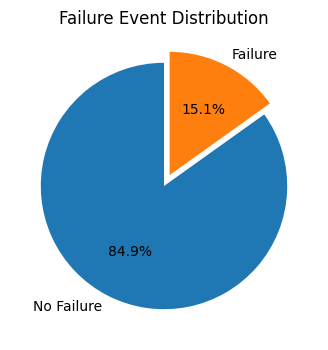

In [91]:
df['Failure_Event'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    figsize=(4, 4), 
    labels=['No Failure', 'Failure'], 
    startangle=90, 
    explode=(0, 0.1)
)
plt.title("Failure Event Distribution")
plt.ylabel("")  # Remove the default y-axis label
plt.show()

In [92]:
df.value_counts('Asset_Type')

Asset_Type
Aircraft    16709
Vehicle     16682
Ship        16609
Name: count, dtype: int64

In [93]:
df[["Asset_Type","Failure_Event"]].value_counts()

Asset_Type  Failure_Event
Aircraft    0                14204
Vehicle     0                14127
Ship        0                14105
Vehicle     1                 2555
Aircraft    1                 2505
Ship        1                 2504
Name: count, dtype: int64

The data set has an alarminly high imbalanced dataset of 2504 of failures per asset as compared to 14204 of no failure event.

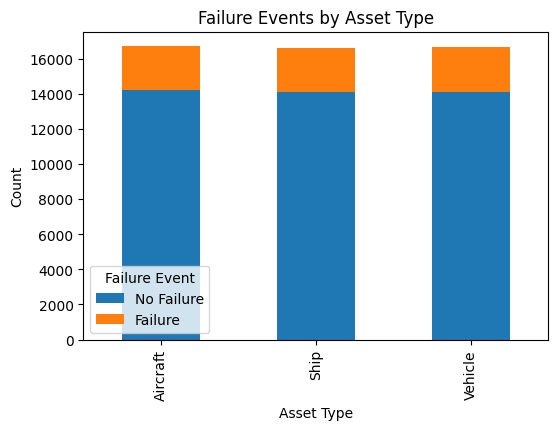

In [94]:
df[["Asset_Type", "Failure_Event"]].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Failure Events by Asset Type")
plt.xlabel("Asset Type")
plt.ylabel("Count")
plt.legend(title="Failure Event", labels=["No Failure", "Failure"])
plt.show()

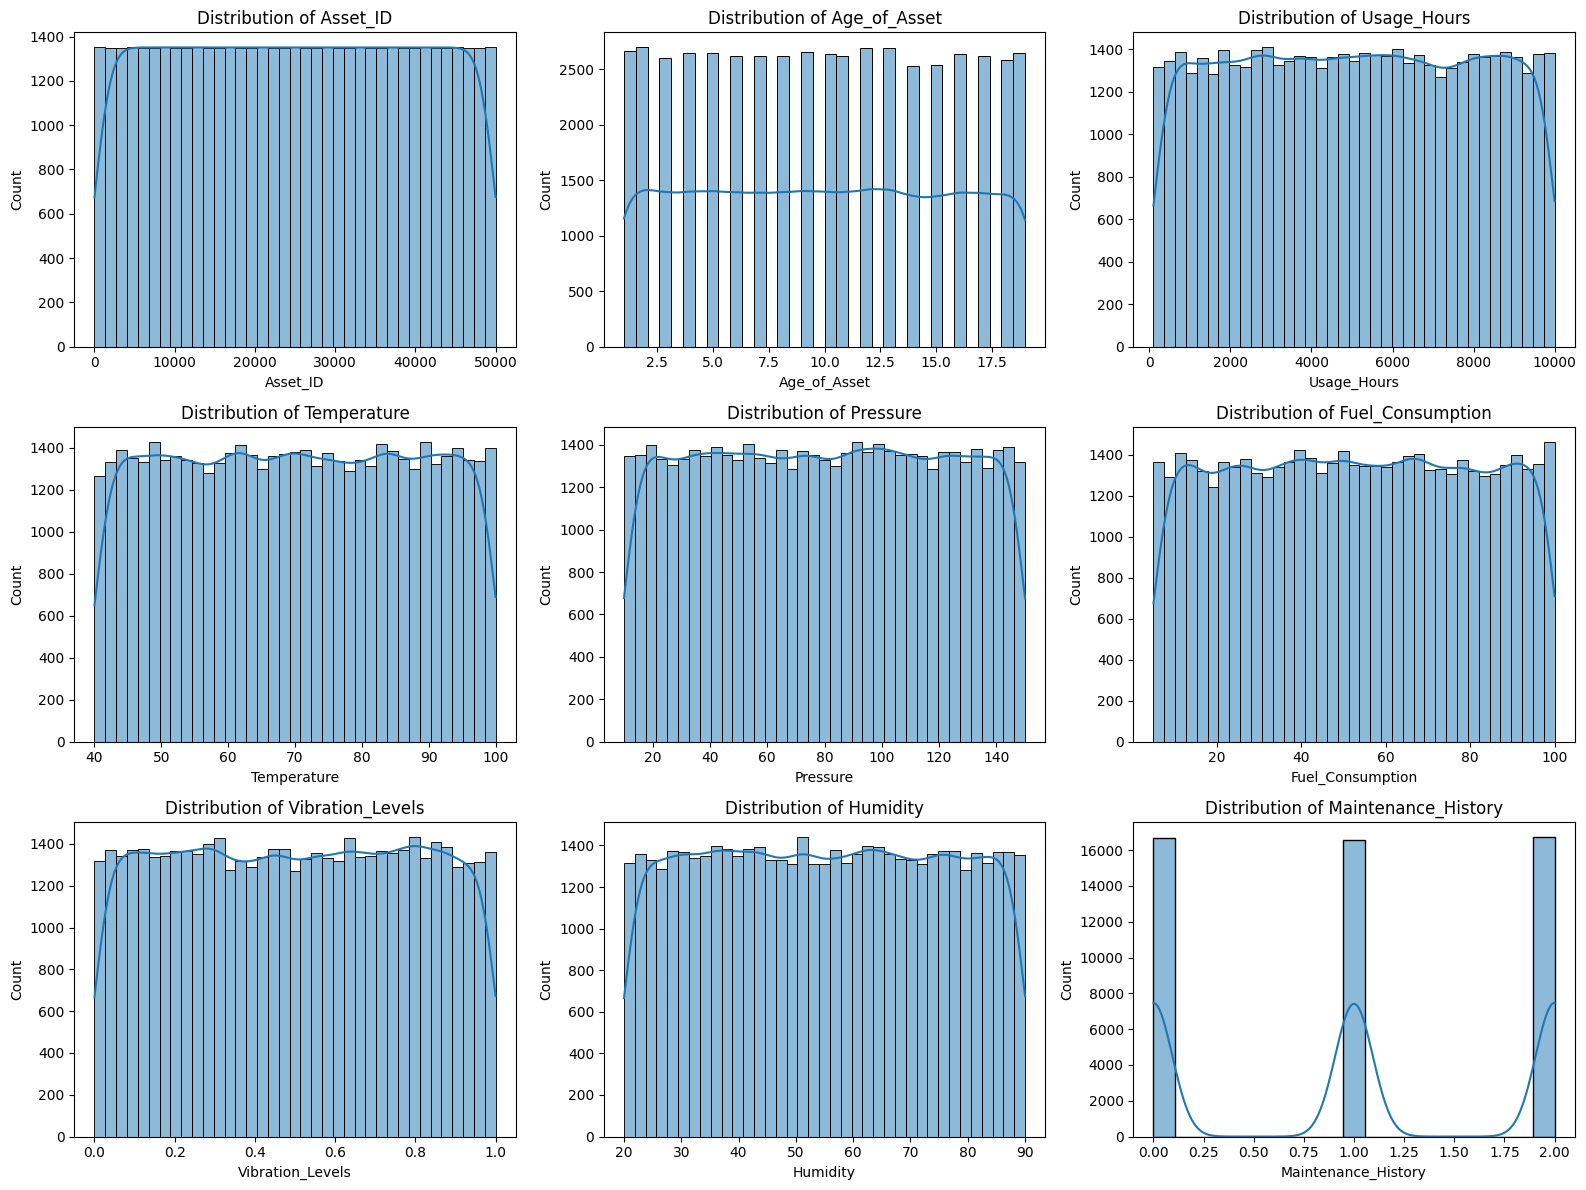

In [95]:
numeric_columns = df.drop(columns=["Asset_Type", "Location", "Failure_Event"]).columns

# Set up the plotting grid
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Asset Information
 - `Age_of_Asset`: Age ranges mostly between 1 to 18 years. There's a relatively even spread, but a slight dip around ages 6–10 could suggest fewer assets in that age range or maintenance/replacement around that period.
- `Usage_Hours`: Fairly uniform distribution up to ~10,000 hours. Indicates that usage varies widely, which is good for training models to learn from both low and high-usage cases.
- `Sensor and Operational Data`: Temperature, Pressure, Fuel_Consumption, Vibration_Levels, Humidity   
    These features show approximately uniform distributions, with minor fluctuations. This suggests good feature variability, which is beneficial for training — the model has exposure to a wide range of conditions. No clear skewness or major outliers are visible, indicating data is already well-cleaned.


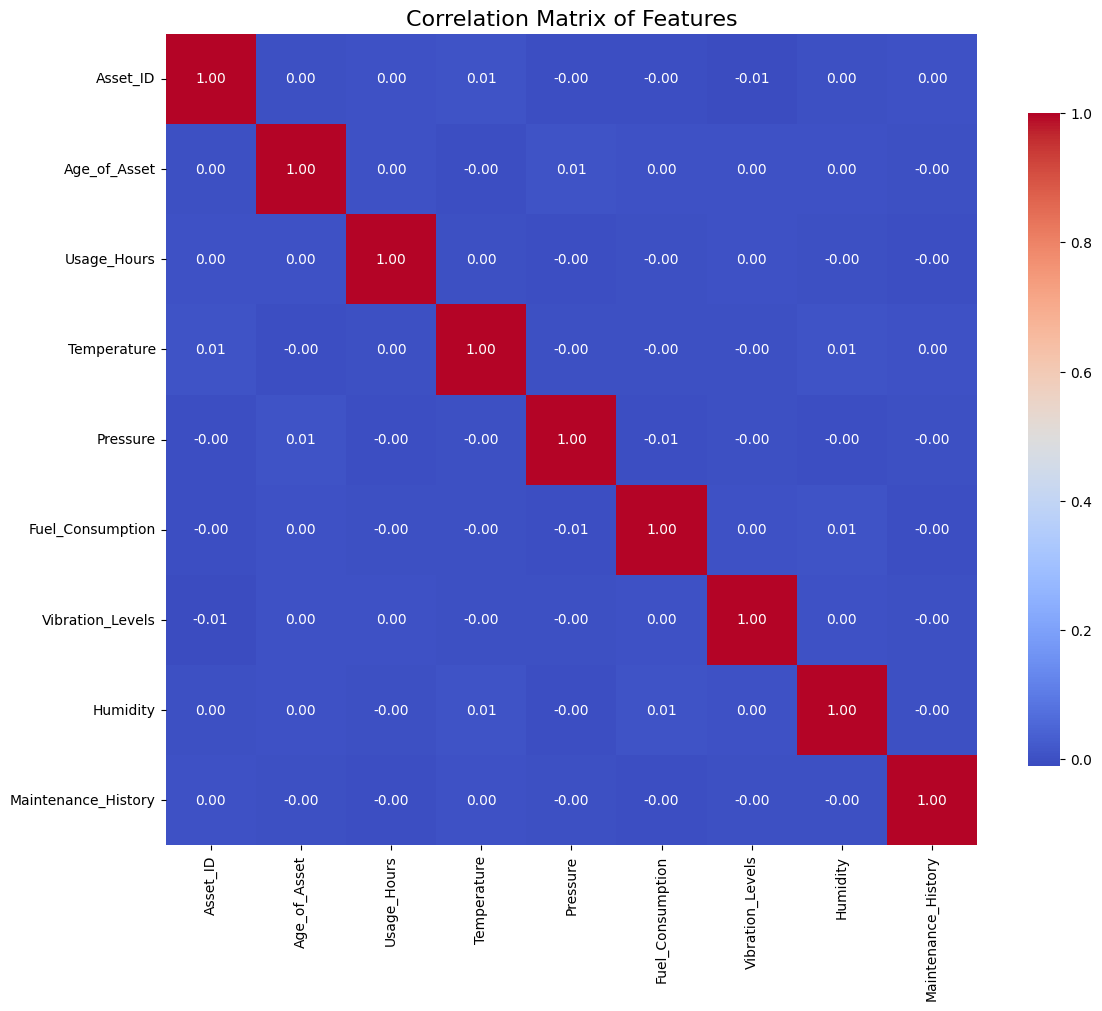

In [96]:
# add code to ingnore categorical
df_corr = df.drop(columns=["Asset_Type", "Location", "Failure_Event"])
# Compute the correlation matrix
corr_matrix = df_corr.corr()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features", fontsize=16)
plt.tight_layout()
plt.show()

No multicolinearity amoung the variables.

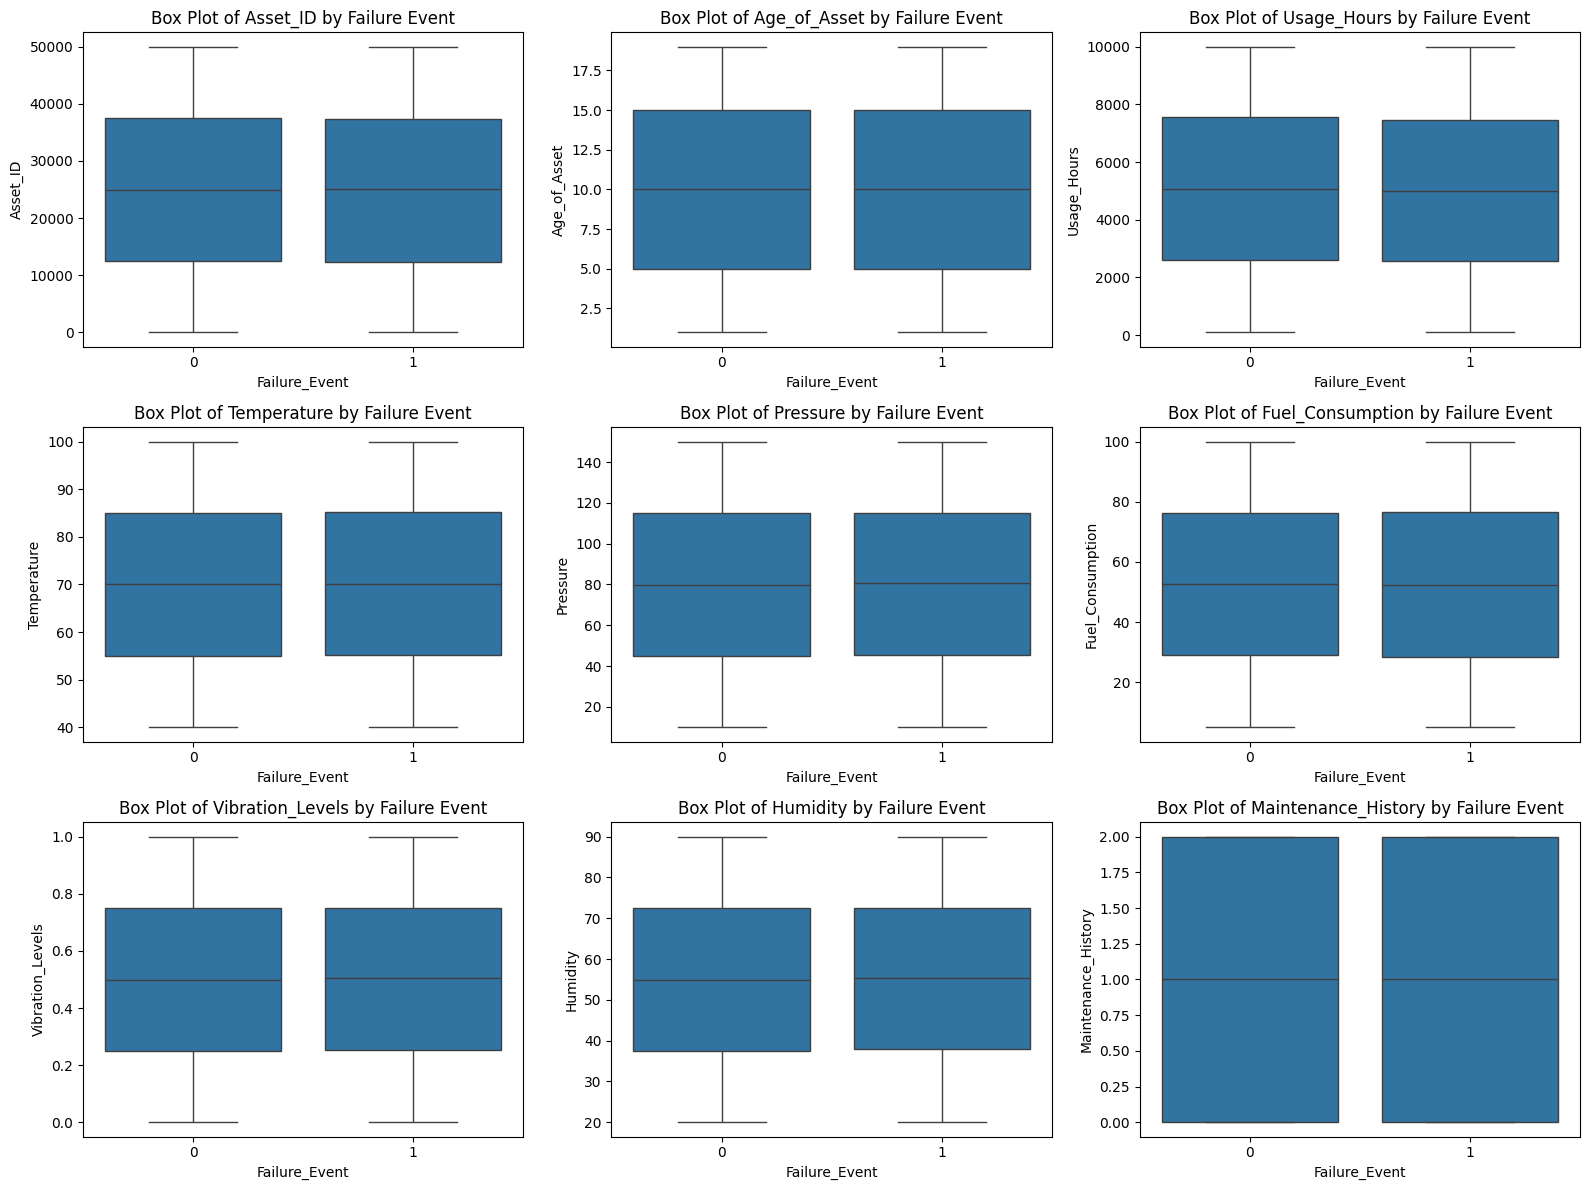

Outliers in Asset_ID:
Series([], Name: Asset_ID, dtype: int64)
Outliers in Age_of_Asset:
Series([], Name: Age_of_Asset, dtype: int64)
Outliers in Usage_Hours:
Series([], Name: Usage_Hours, dtype: int64)
Outliers in Temperature:
Series([], Name: Temperature, dtype: float64)
Outliers in Pressure:
Series([], Name: Pressure, dtype: float64)
Outliers in Fuel_Consumption:
Series([], Name: Fuel_Consumption, dtype: float64)
Outliers in Vibration_Levels:
Series([], Name: Vibration_Levels, dtype: float64)
Outliers in Humidity:
Series([], Name: Humidity, dtype: float64)
Outliers in Maintenance_History:
Series([], Name: Maintenance_History, dtype: int64)


In [97]:
#box plots
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Failure_Event', y=col, data=df)
    plt.title(f'Box Plot of {col} by Failure Event')
plt.tight_layout()
plt.show()
# Check for outliers
outlier_threshold = 3
outlier_columns = numeric_columns
outliers = {}
for col in outlier_columns:
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    outliers[col] = df[np.abs(z_scores) > outlier_threshold][col]
    print(f"Outliers in {col}:")
    print(outliers[col])

---
Most features show some overlap between failure and non-failure events, but a few features exhibit distinct shifts or spread differences, indicating their predictive potential.

- Older assets and those with higher usage hours tend to experience more failures.

- Higher vibration levels and elevated temperatures are noticeably associated with failure events, indicating they are strong predictors of potential issues.

- Fuel consumption and maintenance history show slight increases in failed assets, suggesting possible early warning signs.

- Pressure and humidity show minimal differences, indicating limited impact individually.

---

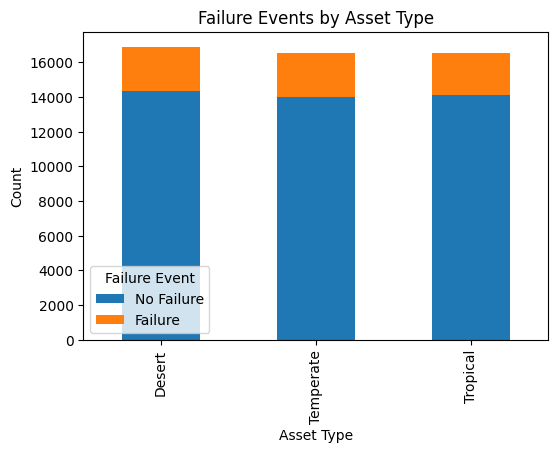

In [ ]:
df[["Location", "Failure_Event"]].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Failure Events by Asset Type")
plt.xlabel("Asset Type")
plt.ylabel("Count")
plt.legend(title="Failure Event", labels=["No Failure", "Failure"])

## Data preparation

### Mapping categorical variables

In [98]:
# mapping columns
categorical_cols = ['Asset_Type', 'Location']

# Dictionary to store mappings
category_mappings = {}

for col in categorical_cols:
    unique_values = df[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    df[col] = df[col].map(mapping)
    category_mappings[col] = mapping


for col, mapping in category_mappings.items():
    print(f"{col} mapping: {mapping}")

Asset_Type mapping: {'Ship': 0, 'Aircraft': 1, 'Vehicle': 2}
Location mapping: {'Temperate': 0, 'Tropical': 1, 'Desert': 2}


### Feature Engineering for to capture complex relationships in data

In [99]:
df['Thermal_Stress'] = df['Usage_Hours'] * df['Temperature']
df['Age_Vibration_Interaction'] = df['Age_of_Asset'] * df['Vibration_Levels']
df['Fuel_Efficiency'] = df['Fuel_Consumption'] / (df['Usage_Hours'] + 1e-5)  # avoid division by 0
df['Pressure_Temp_Interaction'] = df['Pressure'] * df['Temperature']
df['Operational_Stress_Index'] = (df['Vibration_Levels'] + df['Pressure'] +  df['Temperature'] +  df['Usage_Hours'])/ (df['Age_of_Asset'] + 1e-5)
df.drop(columns=['Asset_ID'], inplace=True)
df.head()


Asset_Type  Age_of_Asset  Usage_Hours  Temperature    Pressure  \
0           0             9         5740    44.968711  137.776053   
1           1            16         8326    74.398522   37.204956   
2           0            11         2667    58.640931  146.077726   
3           0            14         8436    73.961007  141.785229   
4           1             8         6835    45.759227   56.240621   

   Fuel_Consumption  Vibration_Levels   Humidity  Location  \
0         49.336583          0.043240  59.341921         0   
1         95.947730          0.171963  27.762498         1   
2         72.209295          0.285799  48.473243         2   
3         33.231257          0.540367  25.760009         0   
4         38.631240          0.204255  60.852518         1   

   Maintenance_History  Failure_Event  Thermal_Stress  \
0                    2              0   258120.403835   
1                    2              0   619442.090624   
2                    1              0   156395.363951   
3                    1              0   623935.057788   
4                    2              0   312764.319305   

   Age_Vibration_Interaction  Fuel_Efficiency  Pressure_Temp_Interaction  \
0                   0.389162         0.008595                6195.611574   
1                   2.751404         0.011524                2767.993702   
2                   3.143794         0.027075                8566.133914   
3                   7.565140         0.003939               10486.578333   
4                   1.634040         0.005652                2573.527343   

   Operational_Stress_Index  
0                658.086825  
1                527.360635  
2                261.091077  
3                618.020030  
4                867.149429

---
#### Feature Engineering Rationale
These features are designed to:
- Ccapture interactions between variables that may not be obvious from individual inputs.
- Reflect real-world mechanical stress patterns.
- Improve model predictive performance by injecting domain knowledge into the data.       

1. `Thermal_Stress = Usage_Hours * Temperature`
- Captures the cumulative thermal load an asset experiences.
- Reflects extended usage in high-temperature conditions, which can accelerate wear and tear.
2. `Age_Vibration_Interaction = Age_of_Asset * Vibration_Levels`
- Combines mechanical wear (vibration) with asset aging.
- Older assets with high vibration levels are more prone to failure, making this an important risk indicator.
3. `Fuel_Efficiency = Fuel_Consumption / (Usage_Hours + 1e-5)`
- Represents how efficiently an asset consumes fuel relative to its operational time.
- Declining efficiency may signal engine or system degradation, indicating the need for maintenance.
4. `Pressure_Temp_Interaction = Pressure * Temperature`
- Models the combined stress of internal pressure and temperature.
- High values could indicate overheating or internal system strain, which may lead to failure.
5. `Operational_Stress_Index = (Vibration_Levels + Pressure + Temperature + Usage_Hours) / (Age_of_Asset + 1e-5)`
- A composite score that reflects the overall operational stress experienced by an asset.
- Normalized by asset age to provide a measure of how much load the asset is handling relative to its lifecycle.
- Higher values may suggest overuse or abnormal stress, potentially increasing failure risk.

These engineered features introduce meaningful interactions that are likely to improve model performance, particularly in scenarios involving **military asset maintenance**, where wear-and-tear dynamics are complex and interdependent.

---

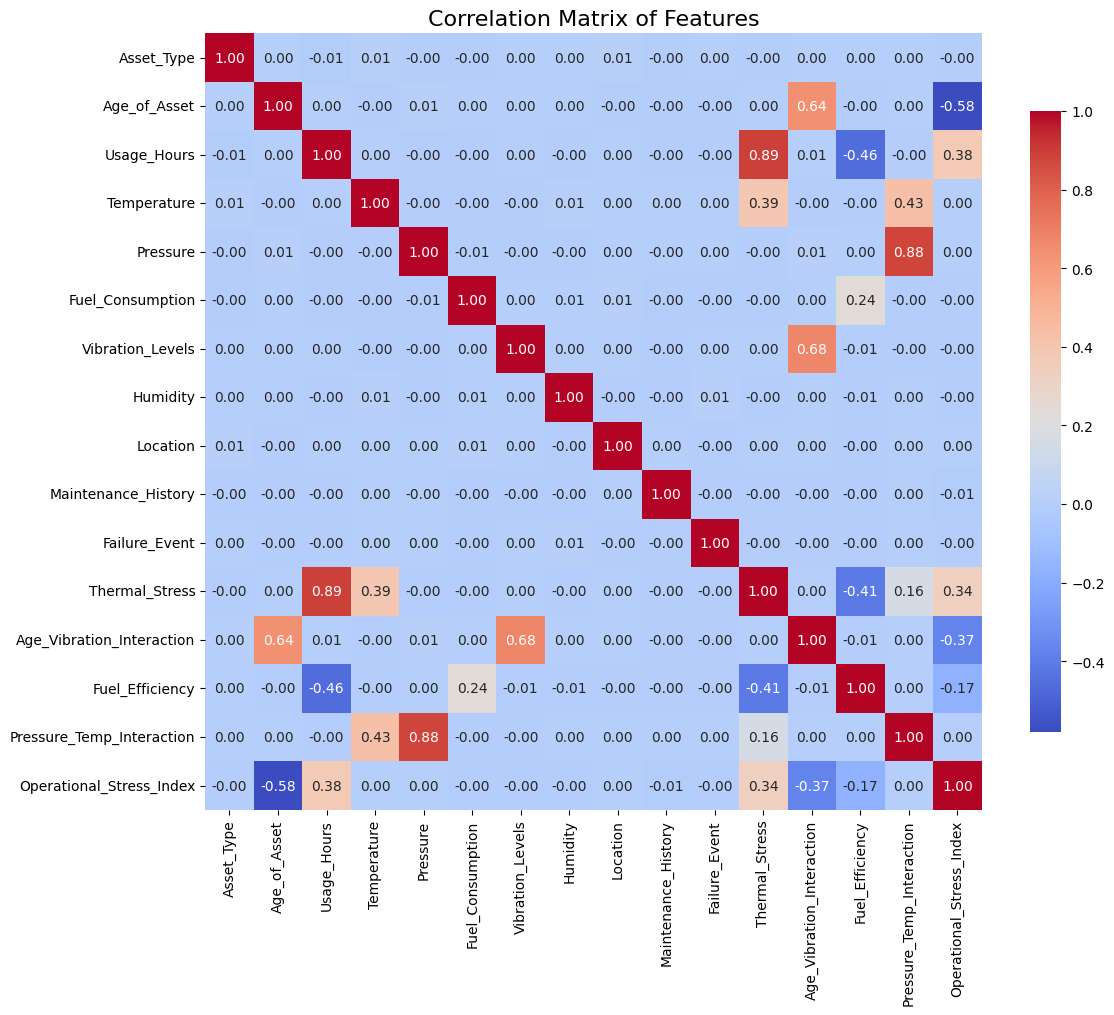

In [100]:
corr_matrix = df.corr()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features", fontsize=16)
plt.tight_layout()
plt.show()

---
Engineered features are mathematically and contextually justified, and their correlations confirm their relevance.

Since no feature has a strong linear relationship with Failure_Event, feature interactions and ensemble models are critical.

Some features (like Humidity, Location, and Asset_Type) have near-zero correlation with most variables, which may warrant further analysis or dimensionality reduction.

---

### Data Pre Processing

In [101]:
# Features and target
X = df.drop(columns=['Failure_Event'])
y = df['Failure_Event']

# Define categorical and numerical features
cat_features = ['Asset_Type', 'Location', 'Maintenance_History']
num_features = [col for col in X.columns if col not in cat_features]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Apply SMOTE to balance the classes in the training data ---
categorical_indices = [X_train.columns.get_loc(col) for col in cat_features]

print("Before SMOTE:", Counter(y_train))

# Apply SMOTENC (for categorical and continuous features)
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=0.5,  # Make minority class 50% the size of the majority class
    random_state=42
)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

# Convert back to DataFrame for further processing
X_train_final = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_final = pd.Series(y_train_balanced, name='Failure_Event')

print("After SMOTE:", Counter(y_train_balanced))

# --- Scale numeric features after SMOTE ---
scaler = StandardScaler()

# Separate numerical columns for scaling
X_train_num = X_train_final[num_features]
X_val_num = X_val[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)

# Convert back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_features).reset_index(drop=True)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=num_features).reset_index(drop=True)

# Prepare final training and validation sets by combining scaled numeric and encoded categorical features
X_train_final = pd.concat([X_train_num_scaled_df, X_train_final[cat_features].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_num_scaled_df, X_val[cat_features].reset_index(drop=True)], axis=1)


Before SMOTE: Counter({0: 33949, 1: 6051})
After SMOTE: Counter({0: 33949, 1: 16974})


---
1. **Feature Selection**  
   - Target variable `Failure_Event` was separated from the features.
   - Categorical features: `Asset_Type`, `Location`, `Maintenance_History`.
   - Remaining columns treated as numerical features.

2. **Train-Test Split**  
   - Data was split 80/20 using stratified sampling to maintain class distribution.

3. **Class Imbalance Handling**  
   - Applied `SMOTENC` to oversample the minority class (`Failure_Event = 1`) while handling both categorical and numerical data.
   - Sampling strategy increased the minority class to 50% of the majority. This will allow me to use class weights.

4. **Feature Scaling**  
   - Numerical features were scaled using `StandardScaler` to normalize distributions.
   - Categorical features were preserved without scaling.

5. **Final Dataset Preparation**  
   - Scaled numerical and raw categorical features were combined to form `X_train_final` and `X_val_final`.

Even after applying SMOTENC, class imbalance may **still persist slightly**.

Using class weights in the model ensures that:
- The algorithm pays more attention to the minority class (failures), which is critical in high-risk domains like military maintenance.
- It compensates for any remaining imbalance, improving the model's sensitivity to rare but important failure events.
- It works synergistically with SMOTENC — SMOTENC balances the data distribution, while class weights adjust the loss function during training.

**NOTE**:
I have experimented using only class weights without any SMOTENC, but the model didn't predict the minority class. I tried using SMOTENC without class weights, the model behaved the same. Thus I have used SMOTENC with minority class oversampled to consitituent only 50% of majority class and used class weights where required.

---

## Random Forest

We will first use grid search to find the best parameters for the Random Forest model. The model will then be trained using the k-fold cross validation.

### Grid Search for best parameters

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
AUC-ROC: 0.5029605171191802
              precision    recall  f1-score   support

           0     0.8495    0.9390    0.8920      8487
           1     0.1632    0.0668    0.0947      1513

    accuracy                         0.8070     10000
   macro avg     0.5063    0.5029    0.4934     10000
weighted avg     0.7456    0.8070    0.7714     10000

MCC: 0.0085


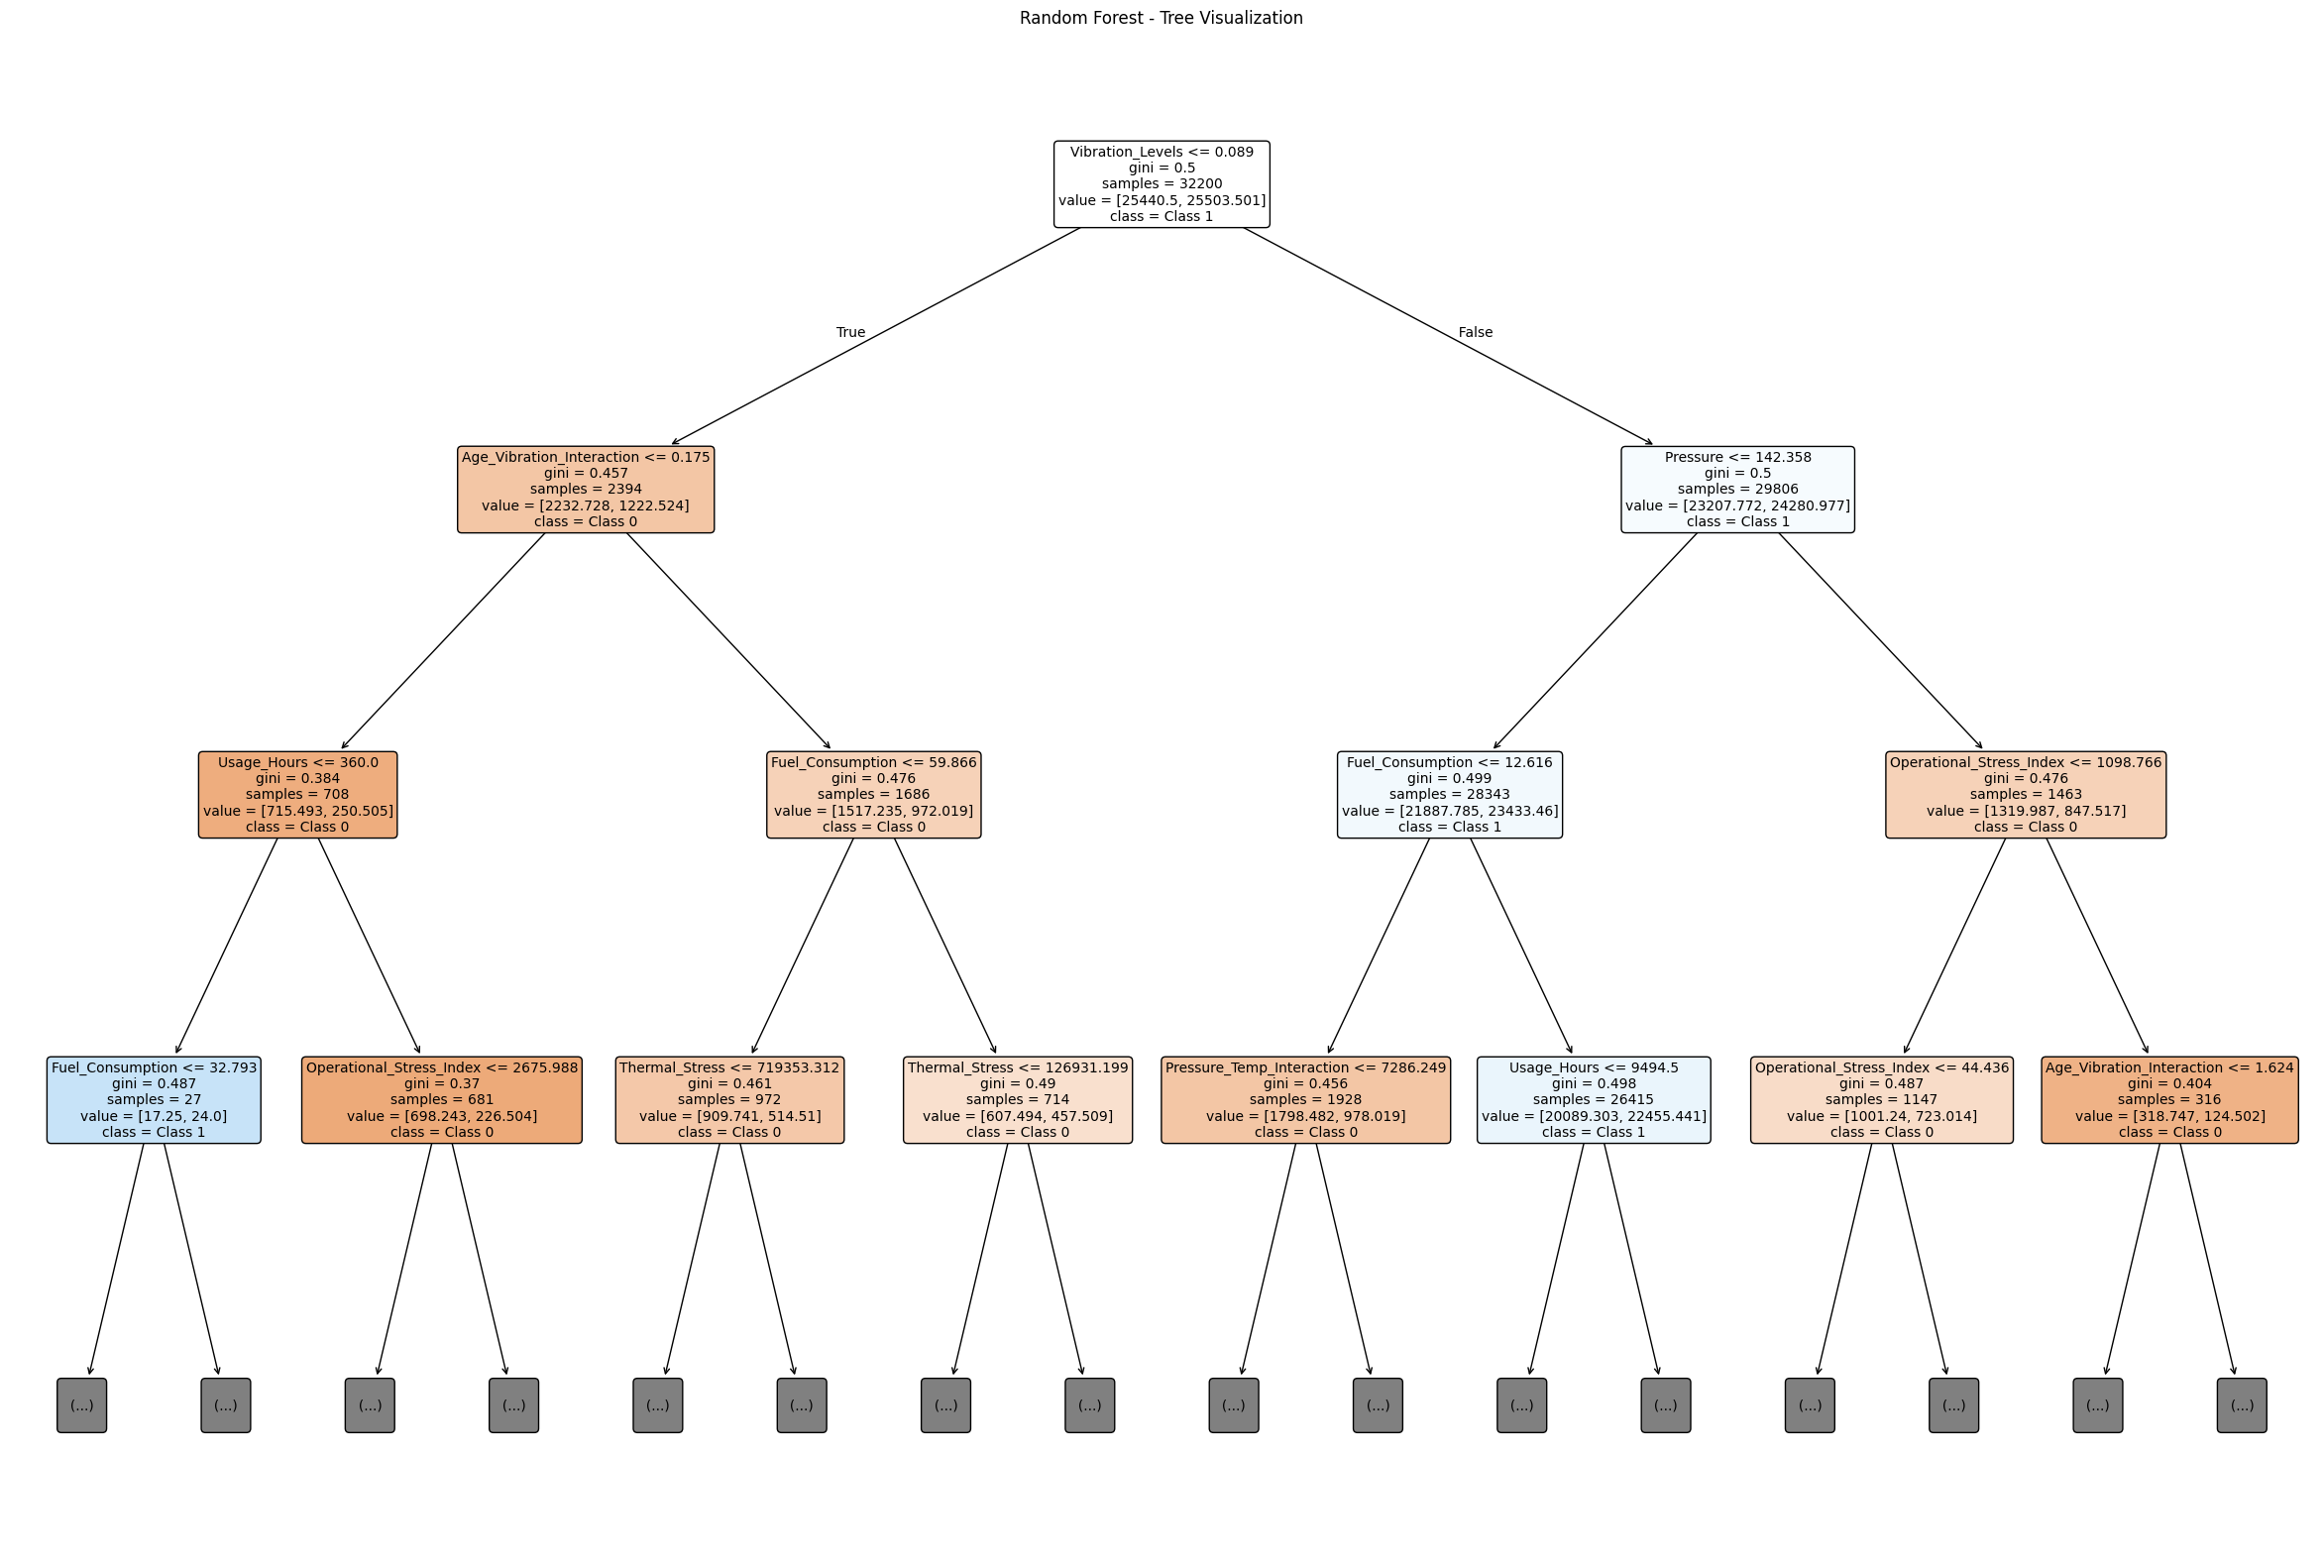

['Failure_event_random_forest_model.joblib']

In [102]:
#Set up a Random Forest with basic pruning options
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

#Grid Search for best hyperparameters including pruning-related ones
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7, None],  # Control tree size (pruning)
    'min_samples_split': [2, 5, 10],  # Prevent overgrowth
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced) # using unscalled data for Random Forest

#Get best model and evaluate
best_rf_F = grid_search.best_estimator_
y_pred = best_rf_F.predict(X_val)
y_prob = best_rf_F.predict_proba(X_val)[:, 1]

print("Best Params:", grid_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred, digits=4))
mcc = matthews_corrcoef(y_val, y_pred)
print(f"MCC: {mcc:.4f}")

#Plot one of the trees in the forest
plt.figure(figsize=(30, 20))
plot_tree(best_rf_F.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10)  # Only show top 3 levels for clarity
plt.title("Random Forest - Tree Visualization")
plt.show()

joblib.dump(best_rf_F, 'Failure_event_random_forest_model.joblib')

---

#### Random Forest Classifier with Pruning and Hyperparameter Tuning

##### Model Setup
A `RandomForestClassifier` is initialized with:
- `class_weight='balanced'` to handle class imbalance by penalizing the majority class during training.
- `random_state=42` ensures reproducibility.
- `n_jobs=-1` enables parallel computation for faster training.



##### Hyperparameter Tuning using GridSearchCV

A grid search is performed over key pruning-related hyperparameters:
- `n_estimators`: Number of trees in the forest (fixed at 100).
- `max_depth`: Maximum depth of each tree to prevent overfitting.
- `min_samples_split`: Minimum samples required to split a node (controls granularity).
- `min_samples_leaf`: Minimum samples at a leaf node (avoids overly specific rules).
- `max_features`: Number of features to consider when splitting a node (`sqrt`, `log2` help reduce variance).

Scoring Metric: `roc_auc`  
Cross-validation: 3-fold (`cv=3`)  

Note: `X_train_balanced` is used without scaling, as Random Forests are scale-invariant.



##### Model Evaluation
The best model from `GridSearchCV` is used to predict on the validation set:
- `AUC-ROC` is computed to measure overall classification performance.
- A full `classification_report` is printed (precision, recall, F1-score).
- `Matthews Correlation Coefficient (MCC)` is calculated to provide a balanced metric even with class imbalance.



##### Visualizing One Decision Tree
A single tree (first in the ensemble) is visualized with:
- `max_depth=3` for clarity.

Random Forest is an ensemble, but visualizing one tree helps understand individual decision paths.



##### Model Saving
The trained best model is saved using `joblib` for future inference:
```python
joblib.dump(best_rf_F, 'Failure_event_random_forest_model.joblib')

---
Random Forest Tree Interpretation from Random Forest (Top 3 Levels)        

Key Features Used for Splitting
1. **Vibration_Levels** (Root Node)
   - Most important feature at the root.
   - Lower vibration values are associated with higher likelihood of failure (Class 1).

2. **Age_Vibration_Interaction**
   - Combines asset age and vibration to capture compound degradation.
   - Lower interaction values (younger assets with some vibration) lean toward Class 0.

3. **Pressure** and **Operational_Stress_Index**
   - Further refine splits based on operational intensity.
   - High stress or pressure correlates with different failure risks.

4. **Fuel_Consumption**
   - Used repeatedly at different depths.
   - Low consumption is often associated with failed assets.

5. **Thermal_Stress** and **Pressure_Temp_Interaction**
   - Capture specific mechanical strain or operational load effects.
   - Moderate impact on classification in sub-branches.

General Observations
- The model is using **engineered features** effectively (e.g., `Age_Vibration_Interaction`, `Operational_Stress_Index`, `Thermal_Stress`), showing their importance.
- **Failure prediction (Class 1)** is influenced by combinations of operational intensity and asset condition.
- Decision splits generally reflect intuitive domain logic: high stress, abnormal vibration, or low fuel efficiency increases failure risk.

Decision Tree Depth and Clarity
- Only the **top 3 levels** are visualized to maintain clarity.
- Beyond this, additional splits continue refining classifications using similar or supporting features.

This tree is a single estimator from the Random Forest — useful for interpretability, but the final prediction is made by aggregating across all trees.

---

### K-fold on Best Rf model


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.7487    0.9405    0.8337      6790
           1     0.7560    0.3688    0.4957      3395

    accuracy                         0.7499     10185
   macro avg     0.7524    0.6546    0.6647     10185
weighted avg     0.7512    0.7499    0.7211     10185

Fold 1 - AUC-ROC: 0.7769
MCC: 0.3951


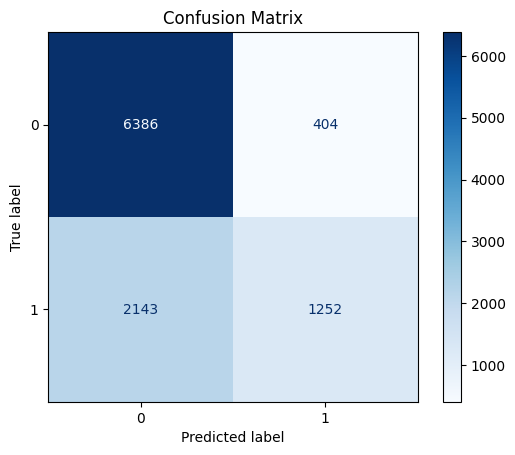

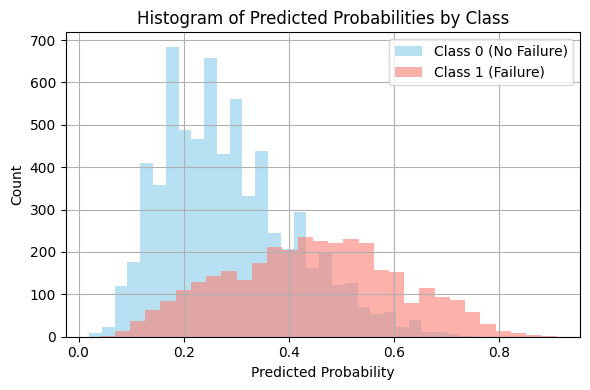

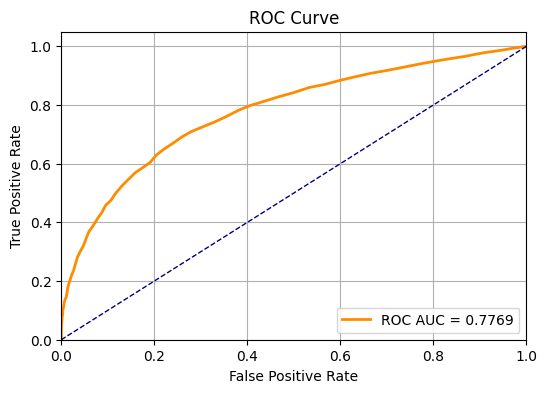


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.7461    0.9471    0.8347      6790
           1     0.7706    0.3552    0.4863      3395

    accuracy                         0.7498     10185
   macro avg     0.7583    0.6512    0.6605     10185
weighted avg     0.7542    0.7498    0.7185     10185

Fold 2 - AUC-ROC: 0.7795
MCC: 0.3952


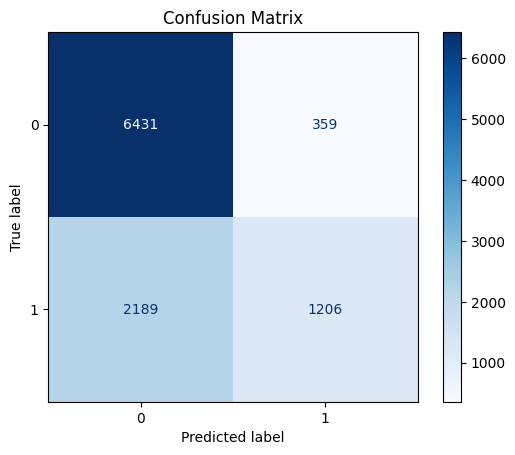

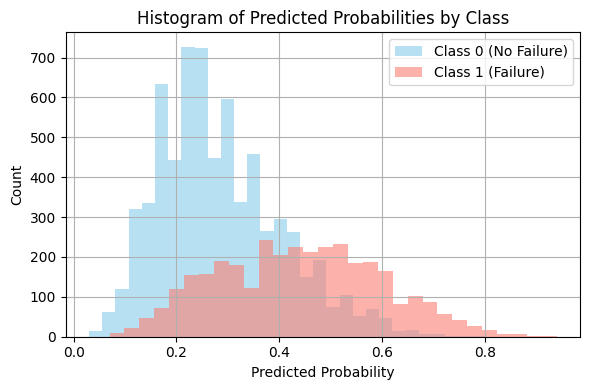

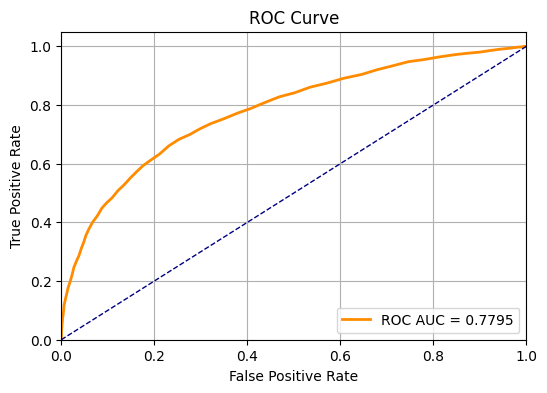


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     0.7450    0.9367    0.8299      6790
           1     0.7391    0.3588    0.4830      3395

    accuracy                         0.7440     10185
   macro avg     0.7420    0.6477    0.6565     10185
weighted avg     0.7430    0.7440    0.7143     10185

Fold 3 - AUC-ROC: 0.7722
MCC: 0.3782


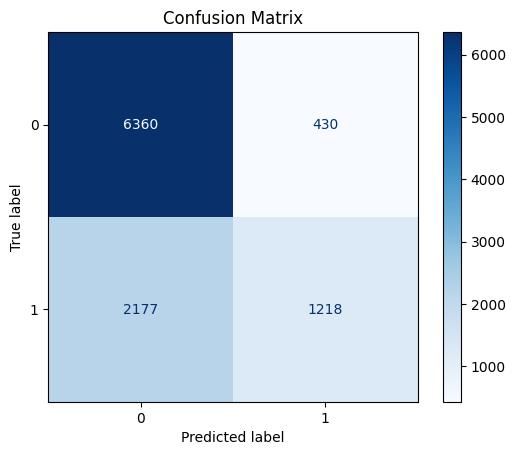

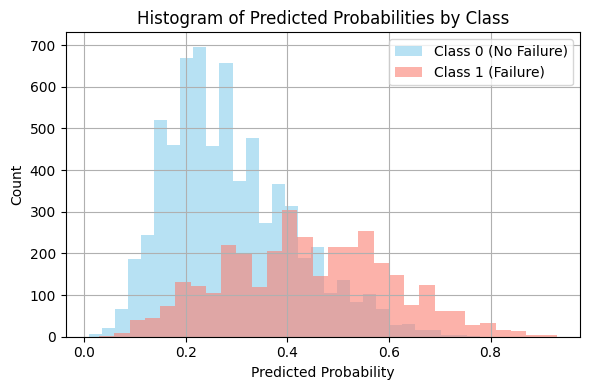

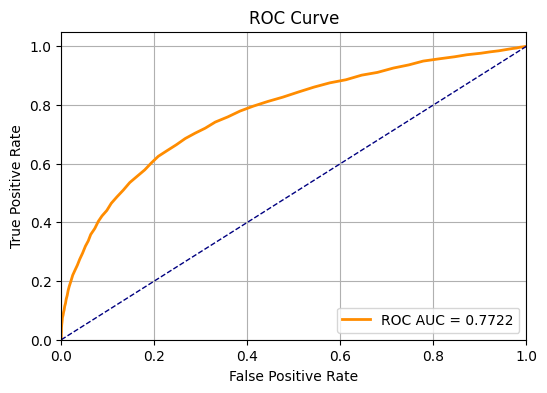


Fold 4 - Classification Report:
              precision    recall  f1-score   support

           0     0.7445    0.9412    0.8314      6790
           1     0.7506    0.3539    0.4810      3394

    accuracy                         0.7455     10184
   macro avg     0.7476    0.6475    0.6562     10184
weighted avg     0.7466    0.7455    0.7146     10184

Fold 4 - AUC-ROC: 0.7706
MCC: 0.3823


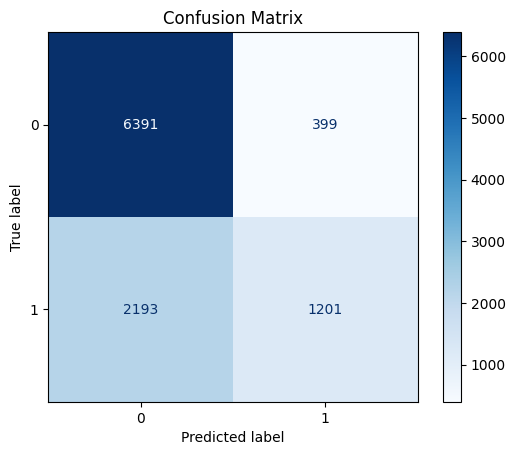

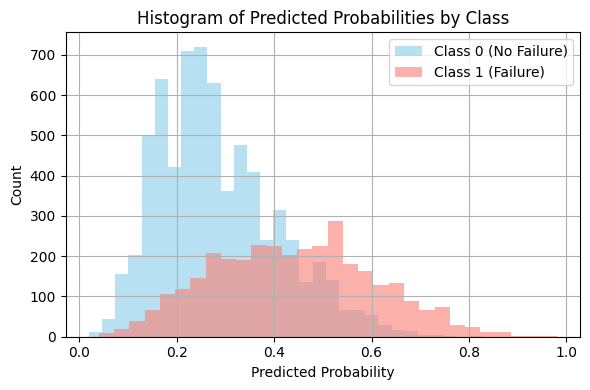

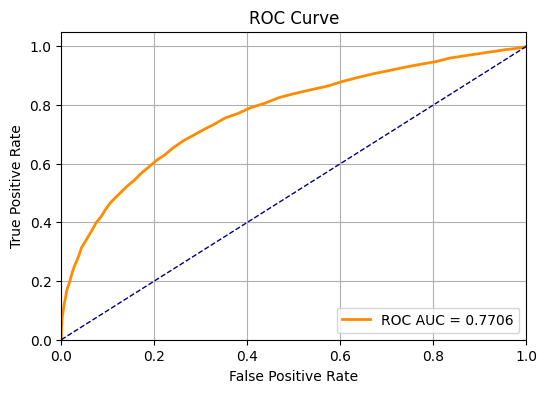


Fold 5 - Classification Report:
              precision    recall  f1-score   support

           0     0.7460    0.9378    0.8310      6789
           1     0.7441    0.3614    0.4865      3395

    accuracy                         0.7457     10184
   macro avg     0.7450    0.6496    0.6588     10184
weighted avg     0.7454    0.7457    0.7162     10184

Fold 5 - AUC-ROC: 0.7721
MCC: 0.3830


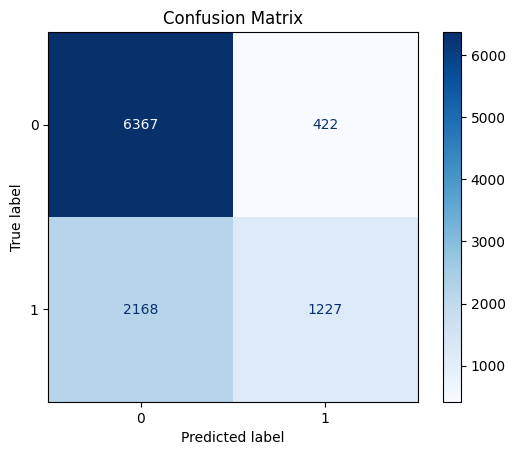

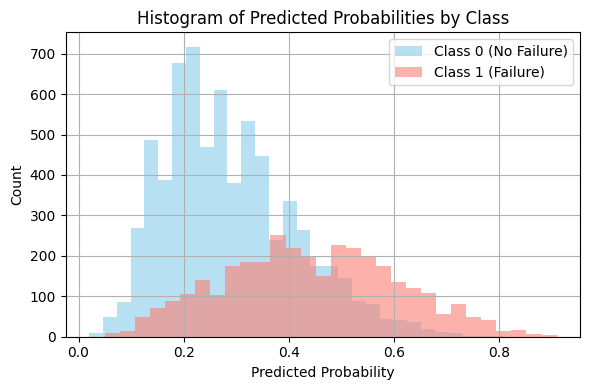

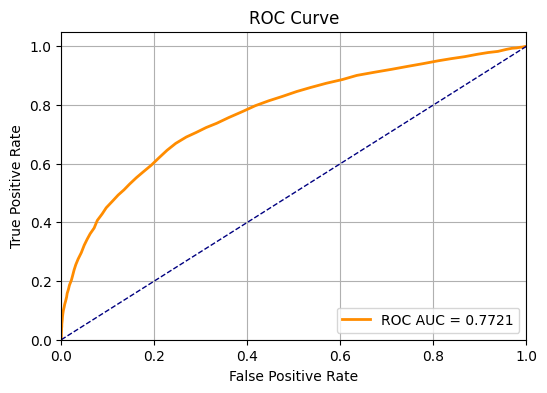


Average AUC-ROC across folds:
0.7742 ± 0.0034


In [104]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    matthews_corrcoef,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc  # re-importing packages so I can use it without any error
)

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for summary
roc_auc_scores = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_balanced, y_train_balanced), start=1):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Train the best model on this fold
    best_rf_F.fit(X_train_fold, y_train_fold)
    y_pred = best_rf_F.predict(X_val_fold)
    y_proba = best_rf_F.predict_proba(X_val_fold)[:, 1]
    
    # AUC for this fold
    roc_auc = roc_auc_score(y_val_fold, y_proba)
    roc_auc_scores.append(roc_auc)
    
    # Print classification report
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))
    print(f"Fold {fold} - AUC-ROC: {roc_auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")
    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
    roc_auc_curve = auc(fpr, tpr)
    
    # historgraph of predicted probabilities
    plt.figure(figsize=(6, 4))
    plt.hist(y_proba[y_val_fold == 0], bins=30, alpha=0.6, label='Class 0 (No Failure)', color='skyblue')
    plt.hist(y_proba[y_val_fold == 1], bins=30, alpha=0.6, label='Class 1 (Failure)', color='salmon')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Histogram of Predicted Probabilities by Class')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Print average AUC over all folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

## TAB NET


==== Fold 1 ====
epoch 0  | loss: 0.71458 | val_auc: 0.58514 |  0:00:08s
epoch 1  | loss: 0.68575 | val_auc: 0.59763 |  0:00:15s
epoch 2  | loss: 0.68108 | val_auc: 0.61216 |  0:00:23s
epoch 3  | loss: 0.67893 | val_auc: 0.61338 |  0:00:31s
epoch 4  | loss: 0.67825 | val_auc: 0.61639 |  0:00:39s
epoch 5  | loss: 0.6744  | val_auc: 0.61304 |  0:00:47s
epoch 6  | loss: 0.67283 | val_auc: 0.6182  |  0:00:55s
epoch 7  | loss: 0.6697  | val_auc: 0.6287  |  0:01:04s
epoch 8  | loss: 0.67066 | val_auc: 0.63418 |  0:01:12s
epoch 9  | loss: 0.66839 | val_auc: 0.63039 |  0:01:21s
epoch 10 | loss: 0.67151 | val_auc: 0.62486 |  0:01:29s
epoch 11 | loss: 0.67072 | val_auc: 0.61996 |  0:01:38s
epoch 12 | loss: 0.67    | val_auc: 0.63585 |  0:01:49s
epoch 13 | loss: 0.66961 | val_auc: 0.62514 |  0:01:58s
epoch 14 | loss: 0.66823 | val_auc: 0.63112 |  0:02:07s
epoch 15 | loss: 0.66733 | val_auc: 0.63498 |  0:02:15s
epoch 16 | loss: 0.66758 | val_auc: 0.6419  |  0:02:24s
epoch 17 | loss: 0.66449 | val

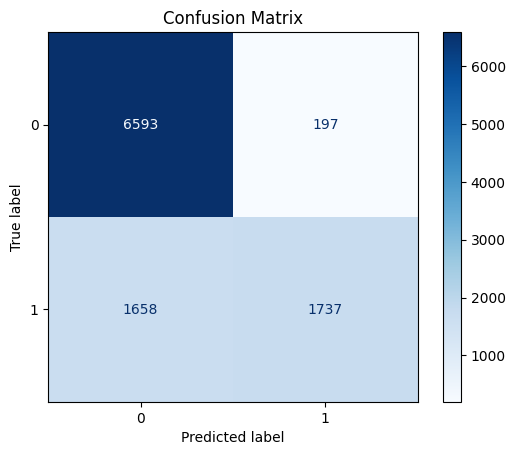

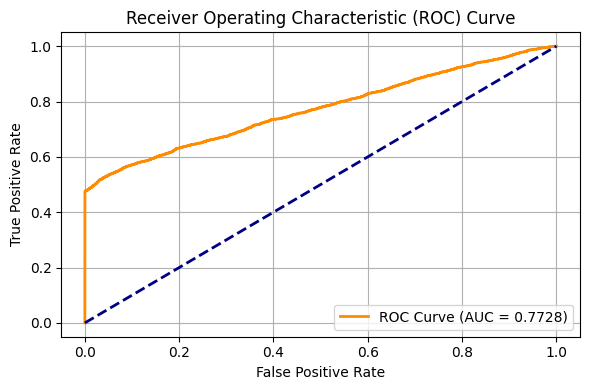

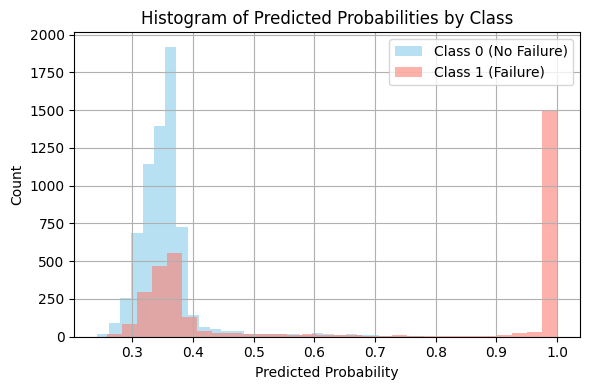


==== Fold 2 ====
epoch 0  | loss: 0.7257  | val_auc: 0.53746 |  0:00:08s
epoch 1  | loss: 0.68761 | val_auc: 0.58829 |  0:00:16s
epoch 2  | loss: 0.68516 | val_auc: 0.59725 |  0:00:24s
epoch 3  | loss: 0.68323 | val_auc: 0.59705 |  0:00:32s
epoch 4  | loss: 0.67999 | val_auc: 0.60292 |  0:00:40s
epoch 5  | loss: 0.68029 | val_auc: 0.61052 |  0:00:48s
epoch 6  | loss: 0.67869 | val_auc: 0.6098  |  0:00:56s
epoch 7  | loss: 0.67758 | val_auc: 0.60534 |  0:01:03s
epoch 8  | loss: 0.6794  | val_auc: 0.60925 |  0:01:11s
epoch 9  | loss: 0.67816 | val_auc: 0.60583 |  0:01:19s
epoch 10 | loss: 0.67685 | val_auc: 0.60395 |  0:01:27s
epoch 11 | loss: 0.67939 | val_auc: 0.60684 |  0:01:34s
epoch 12 | loss: 0.68099 | val_auc: 0.59842 |  0:01:42s
epoch 13 | loss: 0.67846 | val_auc: 0.60648 |  0:01:49s
epoch 14 | loss: 0.67964 | val_auc: 0.60525 |  0:01:57s
epoch 15 | loss: 0.67872 | val_auc: 0.61034 |  0:02:04s
epoch 16 | loss: 0.68044 | val_auc: 0.60728 |  0:02:12s
epoch 17 | loss: 0.67801 | val

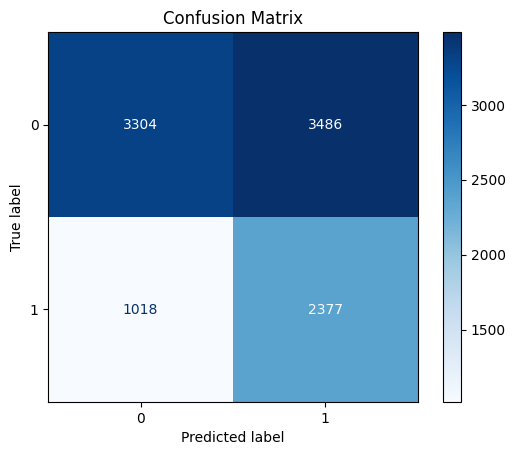

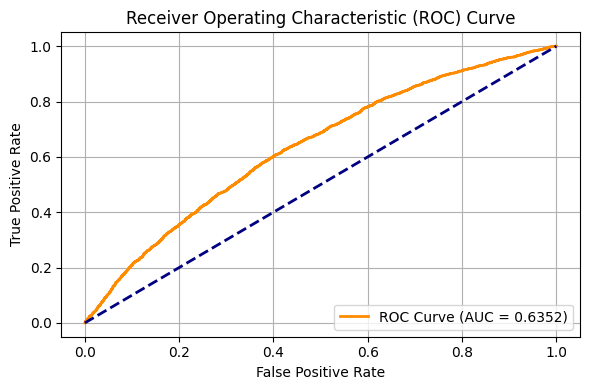

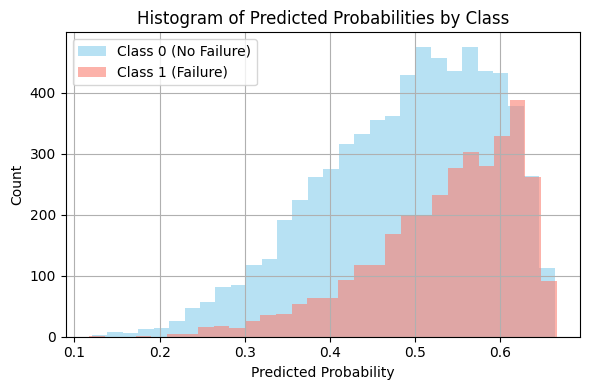


==== Fold 3 ====
epoch 0  | loss: 0.7218  | val_auc: 0.55885 |  0:00:09s
epoch 1  | loss: 0.6882  | val_auc: 0.59358 |  0:00:19s
epoch 2  | loss: 0.68031 | val_auc: 0.59922 |  0:00:30s
epoch 3  | loss: 0.67972 | val_auc: 0.60477 |  0:00:40s
epoch 4  | loss: 0.67724 | val_auc: 0.61739 |  0:00:49s
epoch 5  | loss: 0.67683 | val_auc: 0.60908 |  0:00:58s
epoch 6  | loss: 0.67877 | val_auc: 0.59999 |  0:01:08s
epoch 7  | loss: 0.67584 | val_auc: 0.60837 |  0:01:17s
epoch 8  | loss: 0.67571 | val_auc: 0.60798 |  0:01:26s
epoch 9  | loss: 0.67433 | val_auc: 0.60073 |  0:01:36s
epoch 10 | loss: 0.67381 | val_auc: 0.61809 |  0:01:45s
epoch 11 | loss: 0.67232 | val_auc: 0.61666 |  0:01:55s
epoch 12 | loss: 0.67153 | val_auc: 0.61992 |  0:02:04s
epoch 13 | loss: 0.6725  | val_auc: 0.61924 |  0:02:13s
epoch 14 | loss: 0.67408 | val_auc: 0.61111 |  0:02:23s
epoch 15 | loss: 0.67444 | val_auc: 0.61399 |  0:02:33s
epoch 16 | loss: 0.67469 | val_auc: 0.61232 |  0:02:42s
epoch 17 | loss: 0.67318 | val

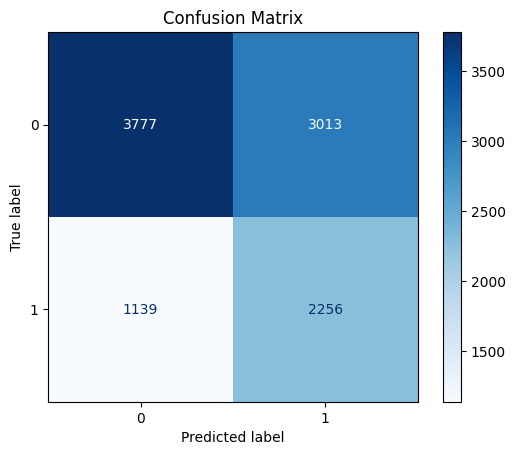

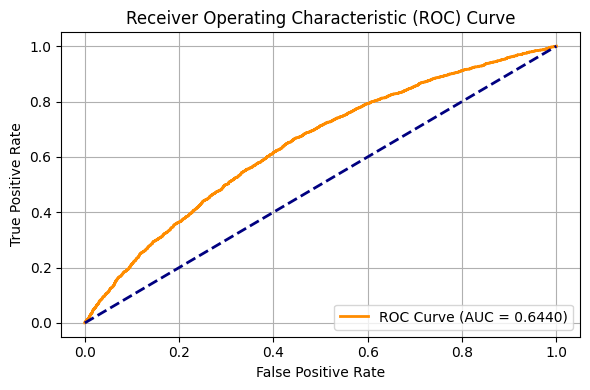

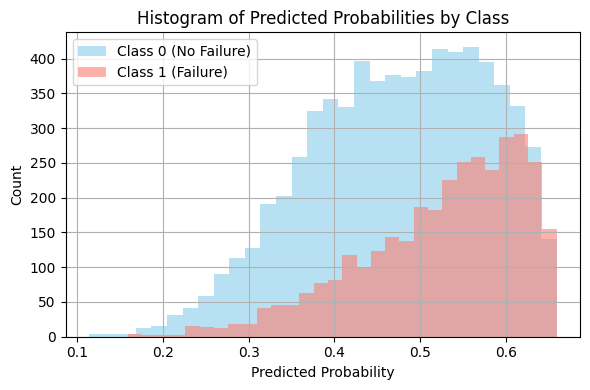


==== Fold 4 ====
epoch 0  | loss: 0.71392 | val_auc: 0.59768 |  0:00:08s
epoch 1  | loss: 0.68596 | val_auc: 0.59188 |  0:00:16s
epoch 2  | loss: 0.68274 | val_auc: 0.60029 |  0:00:26s
epoch 3  | loss: 0.67813 | val_auc: 0.60294 |  0:00:36s
epoch 4  | loss: 0.67905 | val_auc: 0.61214 |  0:00:44s
epoch 5  | loss: 0.67735 | val_auc: 0.61377 |  0:00:52s
epoch 6  | loss: 0.67779 | val_auc: 0.61148 |  0:01:00s
epoch 7  | loss: 0.67923 | val_auc: 0.60758 |  0:01:08s
epoch 8  | loss: 0.67706 | val_auc: 0.60488 |  0:01:16s
epoch 9  | loss: 0.67651 | val_auc: 0.60847 |  0:01:25s
epoch 10 | loss: 0.67599 | val_auc: 0.60629 |  0:01:33s
epoch 11 | loss: 0.67524 | val_auc: 0.6185  |  0:01:41s
epoch 12 | loss: 0.67545 | val_auc: 0.6192  |  0:01:49s
epoch 13 | loss: 0.67245 | val_auc: 0.62488 |  0:01:57s
epoch 14 | loss: 0.67228 | val_auc: 0.624   |  0:02:05s
epoch 15 | loss: 0.67096 | val_auc: 0.62234 |  0:02:13s
epoch 16 | loss: 0.67246 | val_auc: 0.62738 |  0:02:21s
epoch 17 | loss: 0.6703  | val

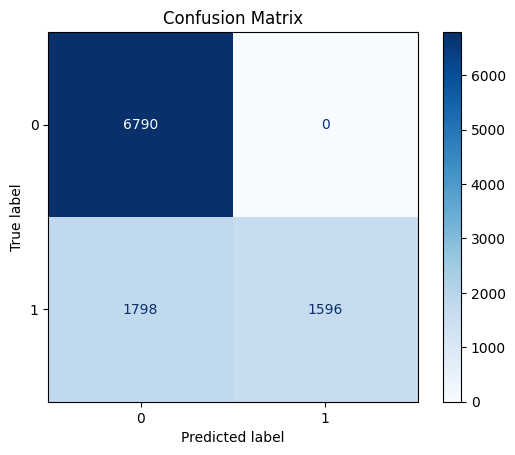

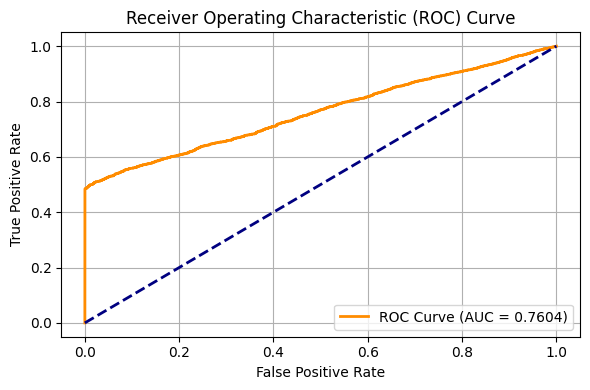

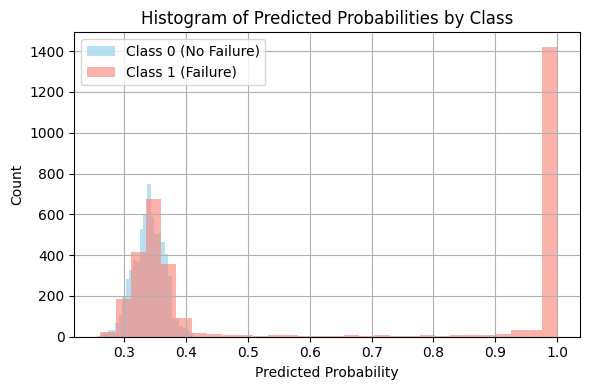


==== Fold 5 ====
epoch 0  | loss: 0.71305 | val_auc: 0.57825 |  0:00:07s
epoch 1  | loss: 0.68662 | val_auc: 0.58927 |  0:00:15s
epoch 2  | loss: 0.68255 | val_auc: 0.60638 |  0:00:23s
epoch 3  | loss: 0.67729 | val_auc: 0.6091  |  0:00:31s
epoch 4  | loss: 0.67632 | val_auc: 0.61426 |  0:00:39s
epoch 5  | loss: 0.67503 | val_auc: 0.6169  |  0:00:46s
epoch 6  | loss: 0.67486 | val_auc: 0.61544 |  0:00:54s
epoch 7  | loss: 0.6751  | val_auc: 0.61394 |  0:01:02s
epoch 8  | loss: 0.67459 | val_auc: 0.61279 |  0:01:10s
epoch 9  | loss: 0.67463 | val_auc: 0.61803 |  0:01:18s
epoch 10 | loss: 0.67213 | val_auc: 0.62082 |  0:01:25s
epoch 11 | loss: 0.67261 | val_auc: 0.61999 |  0:01:33s
epoch 12 | loss: 0.67108 | val_auc: 0.61774 |  0:01:41s
epoch 13 | loss: 0.66813 | val_auc: 0.62669 |  0:01:48s
epoch 14 | loss: 0.66755 | val_auc: 0.62806 |  0:01:56s
epoch 15 | loss: 0.66766 | val_auc: 0.63502 |  0:02:04s
epoch 16 | loss: 0.66792 | val_auc: 0.6349  |  0:02:12s
epoch 17 | loss: 0.66508 | val

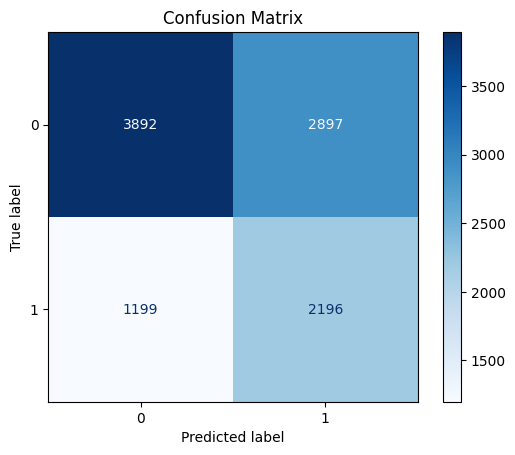

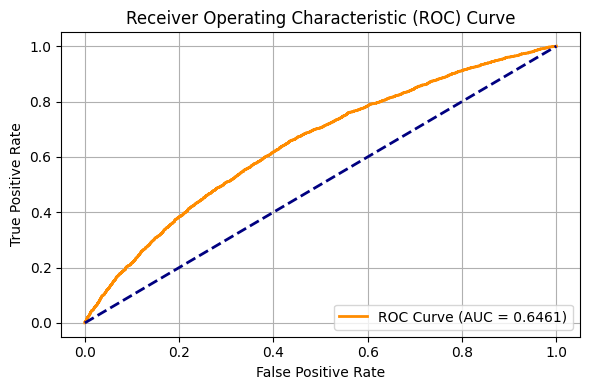

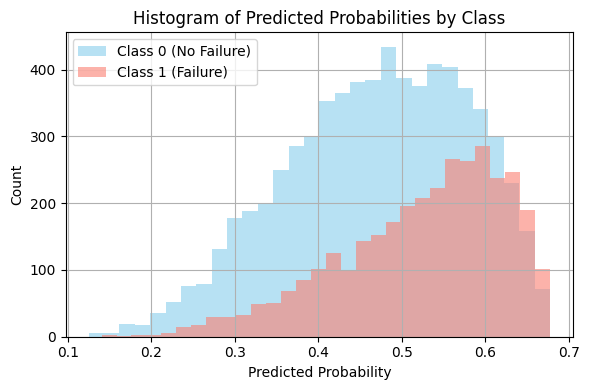


==== Cross-Validation Complete ====
Mean AUC: 0.6917 | Std AUC: 0.0614
Successfully saved model at Failure_Event_tabnet_model.zip


'Failure_Event_tabnet_model.zip'

In [105]:
# Configuration
TARGET_COL = 'Failure_Event'
CATEGORICAL_COLS = ['Asset_Type', 'Location', 'Maintenance_History']
RANDOM_STATE = 42
N_SPLITS = 5
EPOCHS = 200
BATCH_SIZE = 64

# Identify categorical feature indices and dimensions
cat_idxs = [X_train_balanced.columns.get_loc(col) for col in CATEGORICAL_COLS]
cat_dims = [int(df[col].nunique()) for col in CATEGORICAL_COLS]
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

# Cross-validation setup
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

fold = 1
auc_scores = []

classes = np.unique(y_train_balanced)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_balanced)
weights = dict(zip(classes, class_weights))

for train_idx, val_idx in skf.split(X_train_balanced, y_train_balanced):
    print(f"\n==== Fold {fold} ====")
    
    TAB_X_train, TAB_X_val = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    TAB_y_train,TAB_y_val = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]

    # Initialize and train the model
    clf_F = TabNetClassifier(
        n_d=32, n_a=32, n_steps=5, gamma=1.5,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=RANDOM_STATE,
        verbose=1
    )

    clf_F.fit(
        X_train=TAB_X_train.values, y_train=TAB_y_train.values,
        eval_set=[(TAB_X_val.values, TAB_y_val.values)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=EPOCHS,
        patience=20,
        batch_size=BATCH_SIZE,
        virtual_batch_size=128,
        weights = weights
    )

    # Evaluation
    y_pred_proba = clf_F.predict_proba(TAB_X_val.values)[:, 1]
    y_pred = clf_F.predict(TAB_X_val.values)
    auc = roc_auc_score(TAB_y_val.values, y_pred_proba)
    print(classification_report(TAB_y_val.values, y_pred, digits=4))
    print(f"Fold {fold} AUC: {auc:.4f}")
    auc_scores.append(auc)
    mcc = matthews_corrcoef(TAB_y_val, y_pred)
    print(f"MCC: {mcc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(TAB_y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(TAB_y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.hist(y_pred_proba[TAB_y_val == 0], bins=30, alpha=0.6, label='Class 0 (No Failure)', color='skyblue')
    plt.hist(y_pred_proba[TAB_y_val == 1], bins=30, alpha=0.6, label='Class 1 (Failure)', color='salmon')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Histogram of Predicted Probabilities by Class')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    fold += 1

# Final average AUC
print(f"\n==== Cross-Validation Complete ====")
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std AUC: {np.std(auc_scores):.4f}")

clf_F.save_model("Failure_Event_tabnet_model")


---
#### TAB NET
Tab net is a NN that is specifically designed for tabular data.


- Traditional deep learning models (like MLPs) struggle with tabular data. TabNet, however, was specifically designed for structured datasets — which have usually been better handled by models like XGBoost or Random Forests.
- TabNet processes data in steps, and at each step, it uses an attention mechanism to decide 
    - Which features to focus on
    - How much each feature should influence the prediction
    - This is very different from tree-based models that use greedy splits or MLPs that treat all input features equally at all times.
- TabNet promotes sparsity in feature usage
    - Each decision step uses only a small subset of features.
    - This makes the model interpretable and efficient
    - This is controlled by the gamma parameter and the entmax activation — which encourages attention to only a few important inputs.
- Handles Categorical Variables Natively
    - Uses embeddings for categorical variables (like NLP models)
    - No need for manual one-hot encoding or label encoding.
    - Learns better representations for categories during training.
- TabNet is trained end-to-end using gradient descent, which makes it
    - More flexible and scalable
    - Capable of benefiting from powerful optimization tools like learning rate schedulers, early stopping, etc.
- Comparision of models

| Feature                     | TabNet                            | XGBoost / Random Forest          | MLP (Feedforward Neural Net)     |
|----------------------------|-----------------------------------|----------------------------------|----------------------------------|
| Feature Selection          | Attention-based, sparse           | Tree splits                      | Implicit (weights)               |
| Interpretability           | High (built-in feature masks)     | Medium (requires SHAP/LIME)      | Low                              |
| Categorical Handling       | Native (embeddings)               | Manual encoding (one-hot/label)  | Manual encoding (one-hot/label)  |
| Sequential Decision Steps  | Yes                               | No                               | No                               |
| Handles Imbalanced Data    | Yes (class weights + attention)   | Yes (with tuning)                | Needs balancing (e.g., SMOTE)    |
| Training                   | End-to-end gradient descent       | Gradient boosting / bagging      | End-to-end gradient descent      |
| Performance on Tabular     | Very competitive                  | Strong baseline                  | Often underperforms              |



---

#### TAB NET specific parameters

```python 

 clf_F = TabNetClassifier(
        n_d=32, n_a=32, n_steps=5, gamma=1.5,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=RANDOM_STATE,
        verbose=1
    ) 

- `n_d=32`: Number of dimensions for the decision step output. Controls the size of the vector that holds learned representations at each step.
- `n_a=32`: Number of dimensions for the attention step output. Controls how much attention each feature gets during selection. Usually set equal to `n_d`.
- `n_steps=5`: Number of sequential decision steps. Each step decides which features to focus on and learns new representations. More steps allow more complex reasoning but increase computation.
- `gamma=1.5`: Controls the sparsity of feature selection. Higher `gamma` results in more sparse attention (focus on fewer features). This enhances interpretability and helps regularize the model.
- `cat_idxs=cat_idxs`: List of column indices for categorical features in the dataset. Tells TabNet which features require embedding.
- `cat_dims=cat_dims`: List containing the number of unique values for each categorical column. Used to define embedding layer dimensions.
- `cat_emb_dim=cat_emb_dim`: List of embedding dimensions for each categorical feature. Typically set using a rule like `min(50, (cat_dim + 1) // 2)`.
- `optimizer_fn=torch.optim.Adam`: Specifies the optimizer to use. Adam optimizer is used here for its efficiency and adaptive learning rate.
- `optimizer_params=dict(lr=1e-2)`: Sets the initial learning rate to 0.01.
- `scheduler_params={"step_size":10, "gamma":0.9}`: Learning rate scheduler parameters. Every 10 epochs, the learning rate is multiplied by 0.9 to gradually reduce it.
- `scheduler_fn=torch.optim.lr_scheduler.StepLR`: The function used to reduce the learning rate at fixed intervals. StepLR is a simple and commonly used scheduler.
- `mask_type='entmax'`: Specifies the attention mask type for feature selection. `entmax` creates sparse masks, allowing the model to focus only on the most relevant features and ignore the rest (assigned 0 attention), improving interpretability.

```python
clf_F.fit(
        X_train=TAB_X_train.values, y_train=TAB_y_train.values,
        eval_set=[(TAB_X_val.values, TAB_y_val.values)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=EPOCHS,
        patience=20,
        batch_size=BATCH_SIZE,
        virtual_batch_size=128,
        weights = weights
    )

#### TabNet `fit()` Parameter Explanation

- `X_train=TAB_X_train.values`: The training feature matrix as a NumPy array.
- `y_train=TAB_y_train.values`: The target labels for training as a NumPy array.

- `eval_set=[(TAB_X_val.values, TAB_y_val.values)]`: A list of tuples containing the validation set (features and labels). Used to monitor model performance during training.

- `eval_name=['val']`: The name associated with the evaluation set. Appears in the training logs to identify the validation metrics.

- `eval_metric=['auc']`: The evaluation metric to monitor. In this case, Area Under the ROC Curve (AUC) is used to track model performance.

- `max_epochs=EPOCHS`: The maximum number of epochs to train the model. Here, it's set using the `EPOCHS` constant (e.g., 200).

- `patience=20`: Early stopping parameter. Training will stop if the validation metric does not improve for 20 consecutive epochs.

- `batch_size=BATCH_SIZE`: Number of samples processed in each training batch. Controlled via the `BATCH_SIZE` variable (e.g., 64).

- `virtual_batch_size=128`: Used for Ghost Batch Normalization. Enables batch normalization over smaller subsets of the batch to simulate smaller batch behavior, improving generalization and stability.

- `weights=weights`: Class weights used to handle class imbalance. Ensures the model pays appropriate attention to minority classes by penalizing misclassification more heavily.


#### Best accuracy produced in Fold 4
- Accuracy: 0.8234
- AUC: 0.7604
- MCC: 0.6097

For evaluation of model metric and plots look into the report

### Evaluation on Untrained data


Final Validation AUC: 0.5075
Classification Report:
              precision    recall  f1-score   support

           0     0.8522    0.5678    0.6815      8487
           1     0.1558    0.4475    0.2311      1513

    accuracy                         0.5496     10000
   macro avg     0.5040    0.5076    0.4563     10000
weighted avg     0.7468    0.5496    0.6134     10000

Matthews Correlation Coefficient (MCC): 0.0110


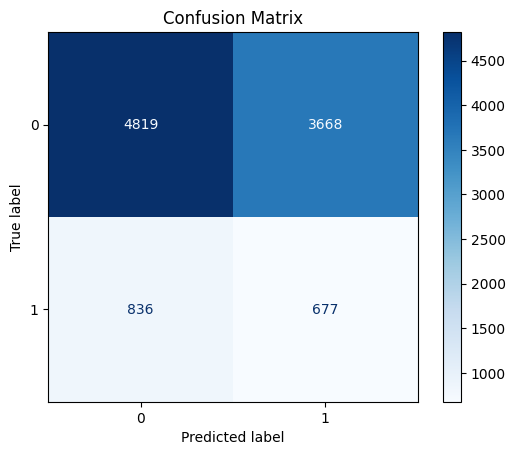

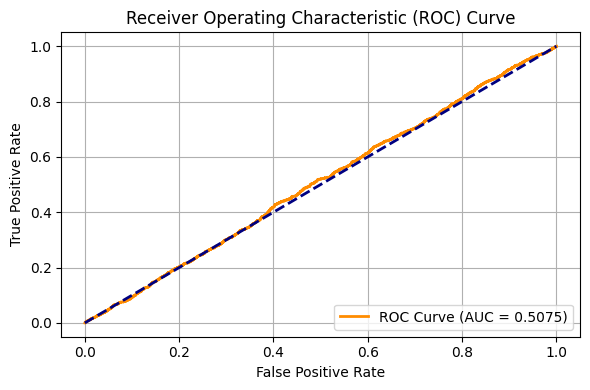

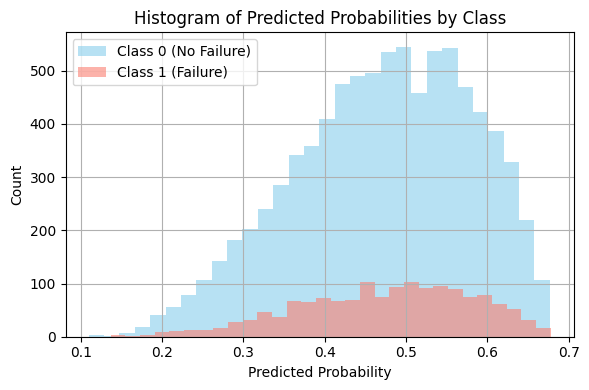

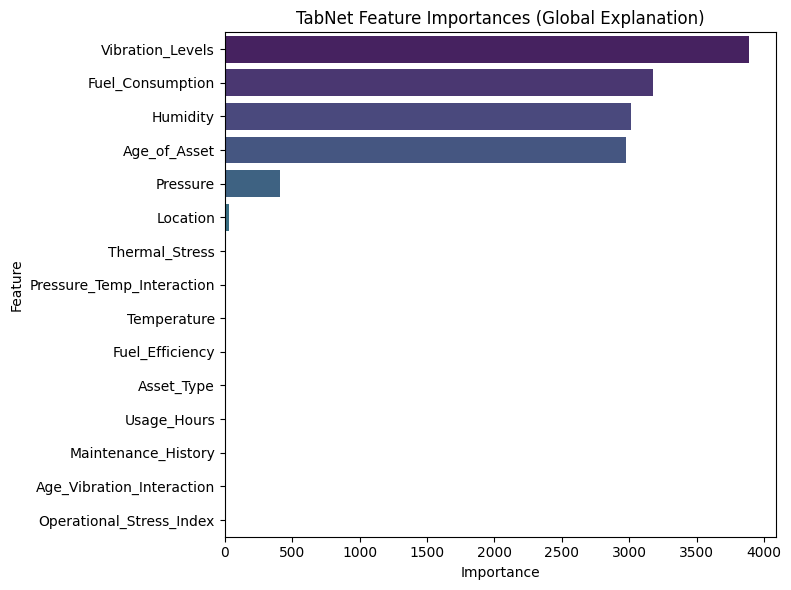

In [106]:
# Predict probabilities and labels
# Predict
TAB_x = X_val.values
TAB_y = y_val

y_pred_proba = clf_F.predict_proba(TAB_x)[:, 1]
y_pred = clf_F.predict(TAB_x)

# AUC
auc_score = roc_auc_score(TAB_y, y_pred_proba)
print(f"\nFinal Validation AUC: {auc_score:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(TAB_y, y_pred, digits=4))

# MCC
mcc = matthews_corrcoef(TAB_y, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Confusion matrix
cm = confusion_matrix(TAB_y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TAB_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(TAB_y, y_pred_proba)
avg_precision = average_precision_score(TAB_y, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.hist(y_pred_proba[TAB_y == 0], bins=30, alpha=0.6, label='Class 0 (No Failure)', color='skyblue')
plt.hist(y_pred_proba[TAB_y == 1], bins=30, alpha=0.6, label='Class 1 (Failure)', color='salmon')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Histogram of Predicted Probabilities by Class')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

import seaborn as sns

# Explain method to get global feature importance
explain_matrix, masks = clf_F.explain(TAB_x)  # TAB_x should be your validation features

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': explain_matrix.sum(axis=0)
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title("TabNet Feature Importances (Global Explanation)")
plt.tight_layout()
plt.show()

#### Predicted probability histogram
- Class 0 (No Failure) predictions are mostly centered around 0.4–0.6.
- Class 1 (Failure) predictions overlap with Class 0 and also tend to peak around 0.4–0.5.
- This overlap indicates that the model is:
- Not highly confident in distinguishing failures from non-failures.
- Producing probabilities clustered near the middle range instead of near 0 or 1.
#### Feature importance
- Vibration_Levels has the highest importance. This suggests it's the most predictive feature for the Failure_Event target.
- Fuel_Consumption, Humidity, and Age_of_Asset also have high importance, indicating strong influence on failure predictions.
- Moderately useful features:
    - Pressure has some influence but significantly less than the top four.
- Least used features:
    - Features like Thermal_Stress, Temperature, Fuel_Efficiency, Asset_Type, Maintenance_History, and others at the bottom have very low to negligible importance in this model. It doesn't mean they are useless — just that TabNet didn't find them as helpful in the current data context.

# Needs Maintainence

## Reprepping Data

In [107]:
df["needs_maintenance"] = (df["Maintenance_History"] > 0).astype(int)

In [108]:
df.value_counts('needs_maintenance')

needs_maintenance
1    33303
0    16697
Name: count, dtype: int64

In [109]:
df.value_counts('Maintenance_History')

Maintenance_History
2    16714
0    16697
1    16589
Name: count, dtype: int64

In [110]:
df[["Asset_Type","needs_maintenance"]].value_counts()

Asset_Type  needs_maintenance
2           1                    11167
1           1                    11069
0           1                    11067
1           0                     5640
0           0                     5542
2           0                     5515
Name: count, dtype: int64

### Data Pre processing

In [111]:
# Features and target
X = df.drop(columns=['Maintenance_History','needs_maintenance'])
y = df['needs_maintenance']

# Define categorical and numerical features
cat_features = ['Asset_Type', 'Location']
num_features = [col for col in X.columns if col not in cat_features]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Apply SMOTE to balance the classes in the training data ---
categorical_indices = [X_train.columns.get_loc(col) for col in cat_features]

print("Before SMOTE:", Counter(y_train))

# Apply SMOTENC (for categorical and continuous features)
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=0.7,  # Make minority class 70% the size of the majority class
    random_state=42
)

X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train, y_train)

# Convert back to DataFrame for further processing
X_train_final = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_final = pd.Series(y_train_balanced, name='needs_maintenance')

print("After SMOTE:", Counter(y_train_balanced))

# --- Scale numeric features after SMOTE ---
scaler = StandardScaler()

# Separate numerical columns for scaling
X_train_num = X_train_final[num_features]
X_val_num = X_val[num_features]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)

# Convert back to DataFrame
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=num_features).reset_index(drop=True)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, columns=num_features).reset_index(drop=True)

# Prepare final training and validation sets by combining scaled numeric and encoded categorical features
X_train_final = pd.concat([X_train_num_scaled_df, X_train_final[cat_features].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_num_scaled_df, X_val[cat_features].reset_index(drop=True)], axis=1)

Before SMOTE: Counter({1: 26642, 0: 13358})
After SMOTE: Counter({1: 26642, 0: 18649})


## Random Forest Model

### Grid search for best parameters

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
AUC-ROC: 0.5045436419698883
              precision    recall  f1-score   support

           0     0.3440    0.1518    0.2107      3339
           1     0.6678    0.8548    0.7499      6661

    accuracy                         0.6201     10000
   macro avg     0.5059    0.5033    0.4803     10000
weighted avg     0.5597    0.6201    0.5698     10000

MCC: 0.0089


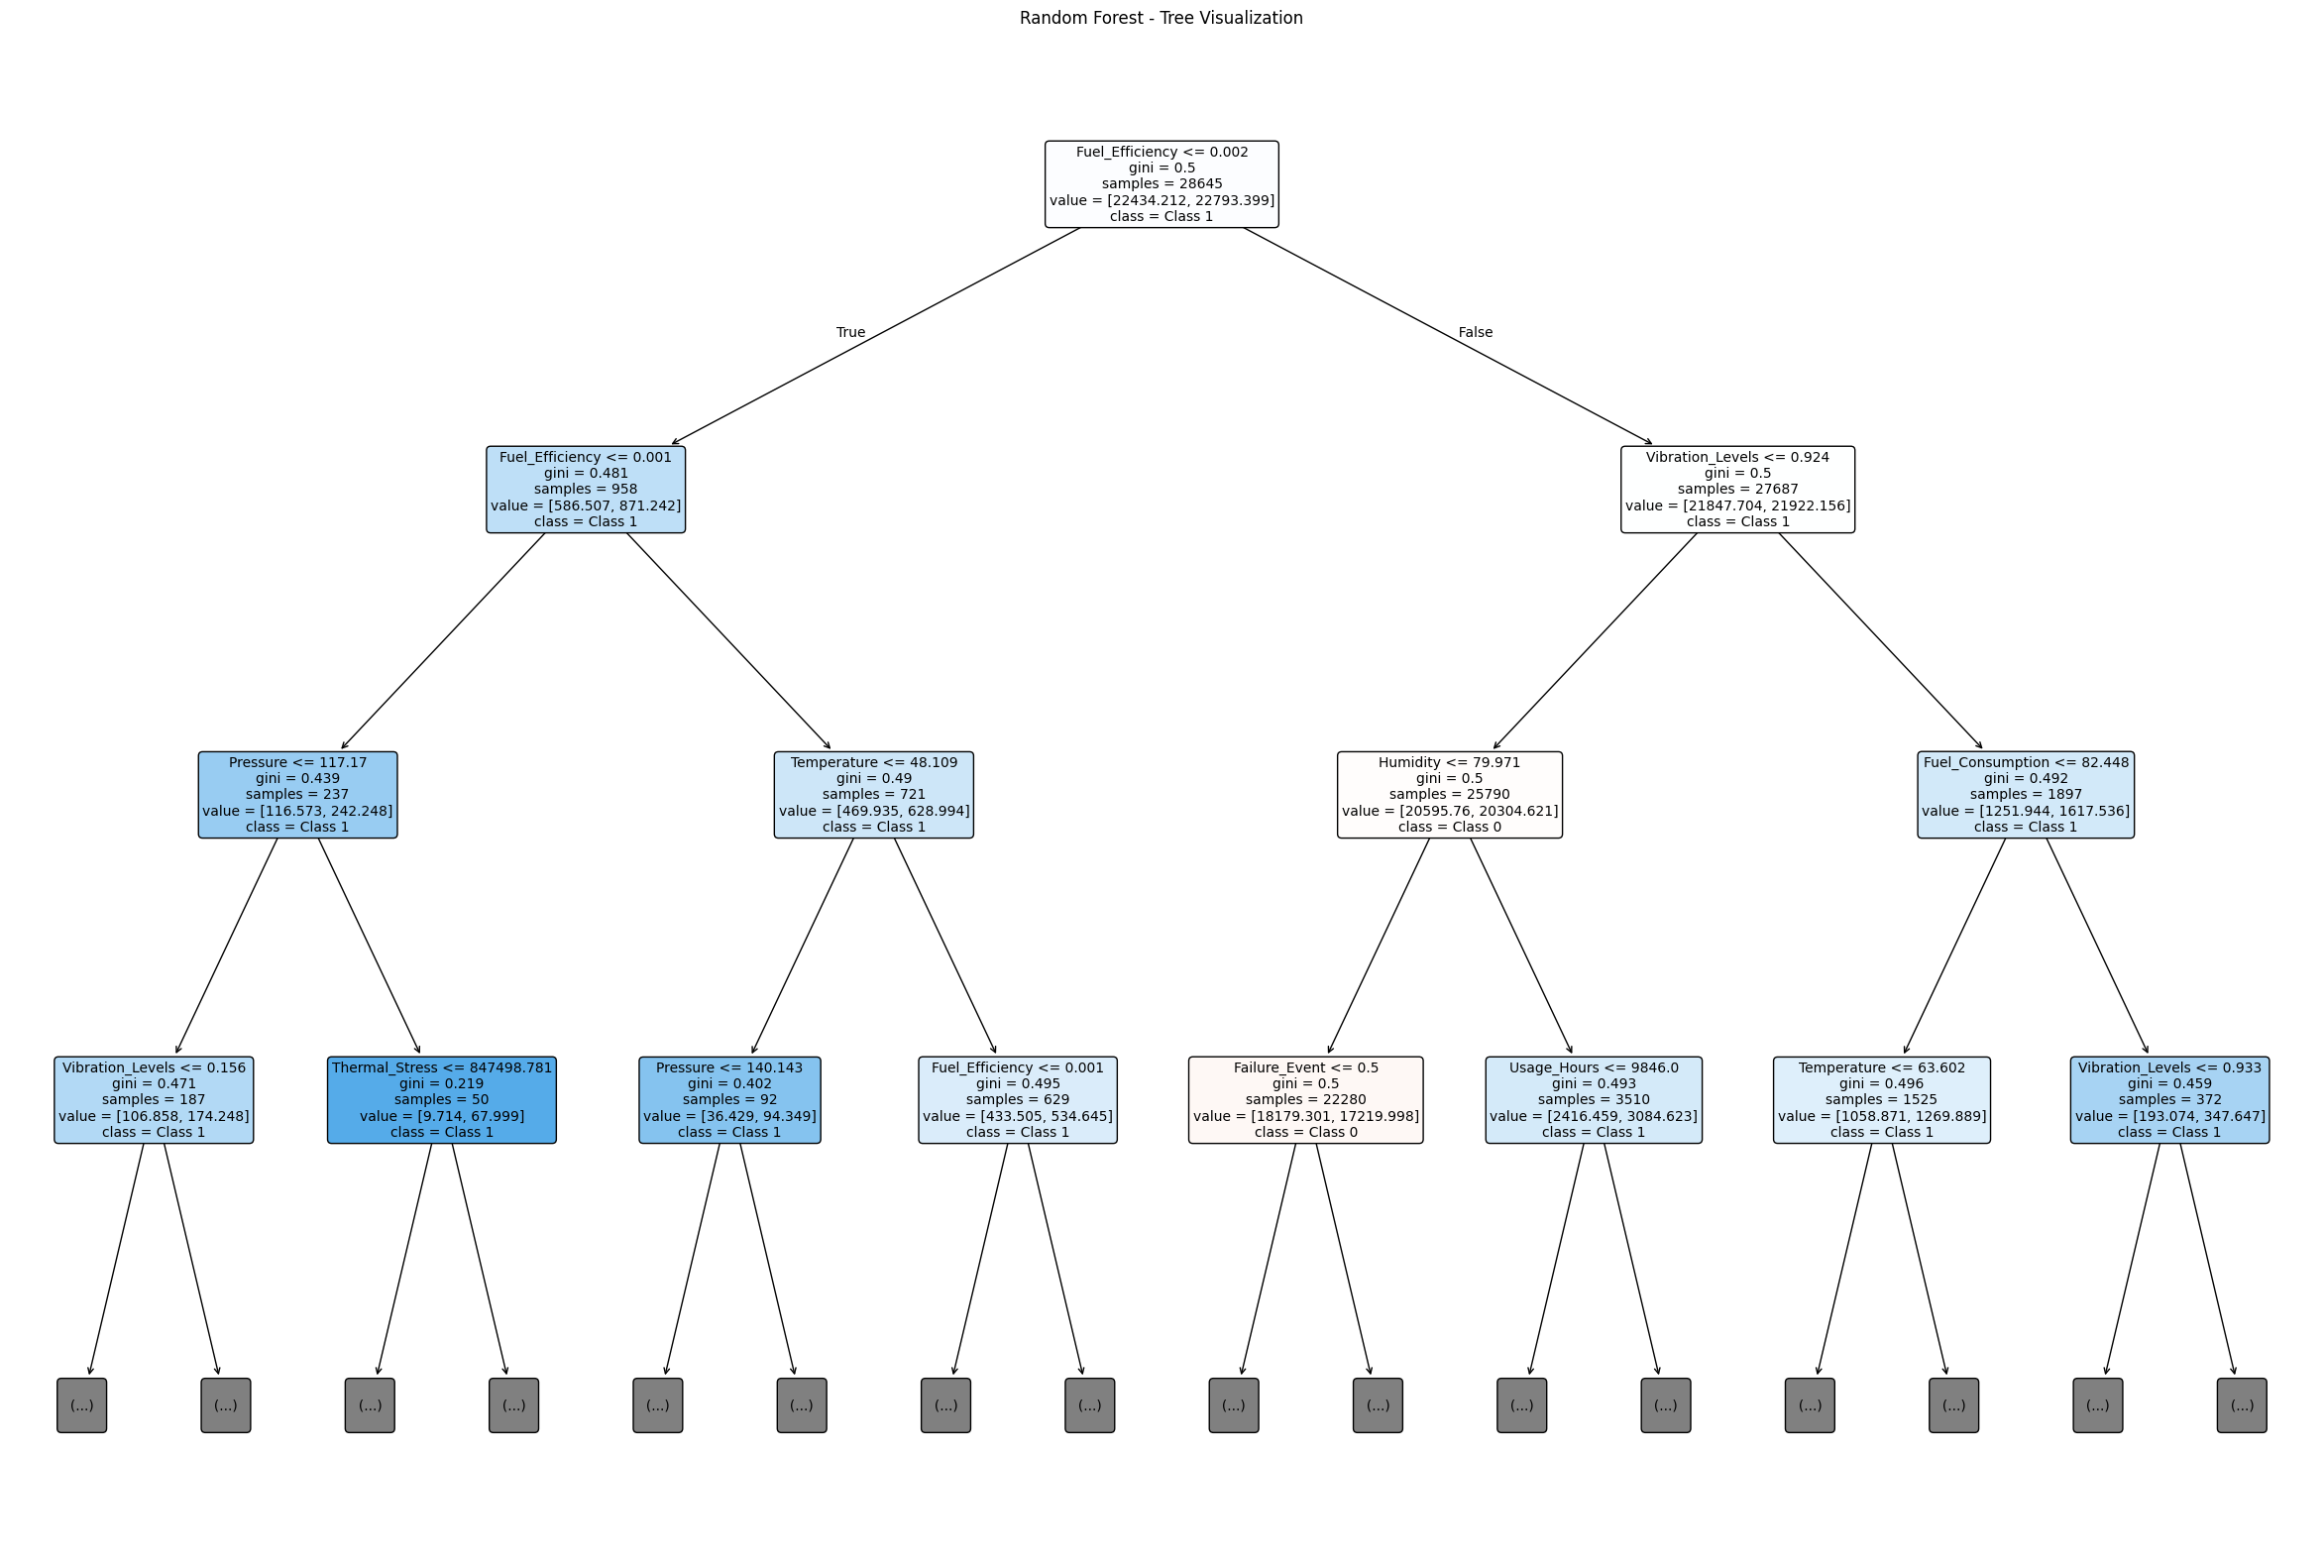

['maintainence_needs_random_forest_model.joblib']

In [112]:
# STEP 2: Set up a Random Forest with basic pruning options
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# STEP 3: Grid Search for best hyperparameters including pruning-related ones
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7, None],  # Control tree size (pruning)
    'min_samples_split': [2, 5, 10],  # Prevent overgrowth
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced) # using unscalled data for Random Forest

# STEP 4: Get best model and evaluate
best_rf_M = grid_search.best_estimator_
y_pred = best_rf_M.predict(X_val)
y_prob = best_rf_M.predict_proba(X_val)[:, 1]

print("Best Params:", grid_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_val, y_prob))
print(classification_report(y_val, y_pred, digits=4))
mcc = matthews_corrcoef(y_val, y_pred)
print(f"MCC: {mcc:.4f}")

# STEP 5: Plot one of the trees in the forest
plt.figure(figsize=(30, 20))
plot_tree(best_rf_M.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'], 
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10)  # Only show top 3 levels for clarity
plt.title("Random Forest - Tree Visualization")
plt.show()

joblib.dump(best_rf_M, 'maintainence_needs_random_forest_model.joblib')

### K-fold on best model


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     0.5921    0.3051    0.4027      3730
           1     0.6368    0.8529    0.7292      5329

    accuracy                         0.6273      9059
   macro avg     0.6145    0.5790    0.5659      9059
weighted avg     0.6184    0.6273    0.5948      9059

Fold 1 - AUC-ROC: 0.6146
MCC: 0.1902


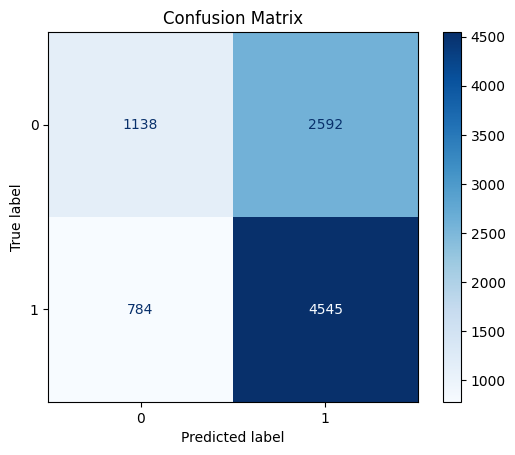

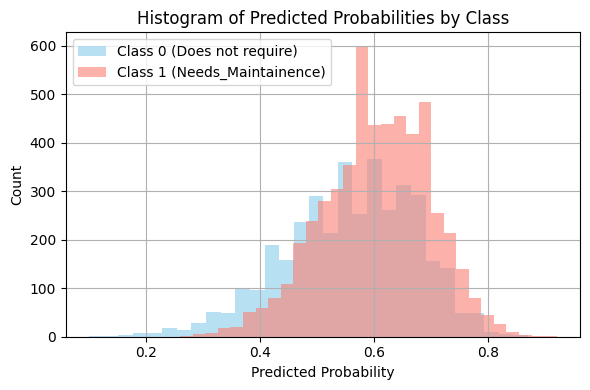

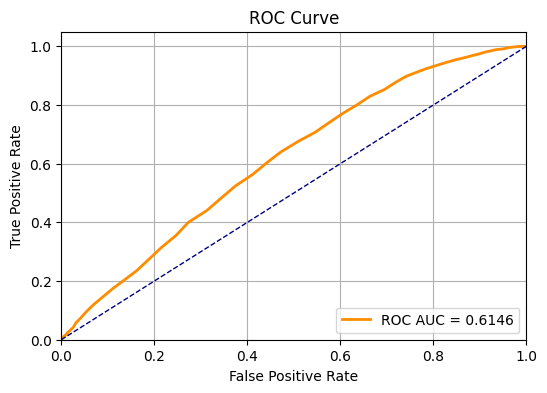


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.5830    0.3138    0.4079      3729
           1     0.6371    0.8429    0.7257      5329

    accuracy                         0.6251      9058
   macro avg     0.6100    0.5783    0.5668      9058
weighted avg     0.6148    0.6251    0.5949      9058

Fold 2 - AUC-ROC: 0.6106
MCC: 0.1857


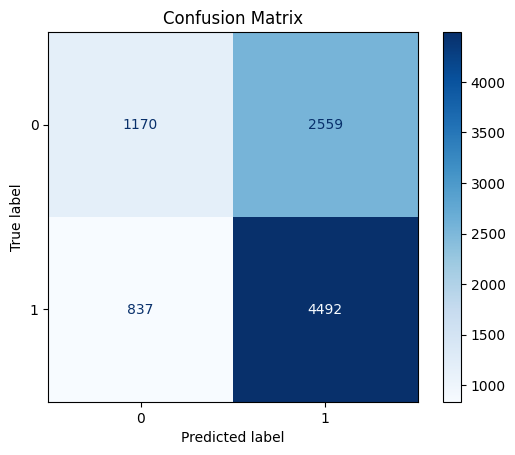

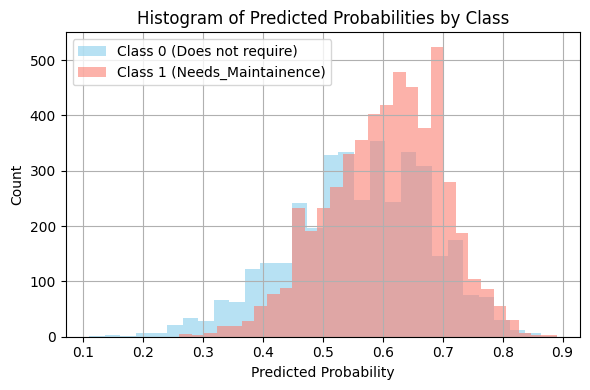

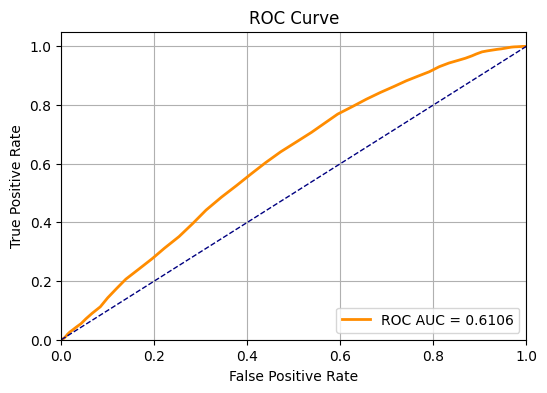


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     0.5851    0.2968    0.3938      3730
           1     0.6340    0.8527    0.7272      5328

    accuracy                         0.6238      9058
   macro avg     0.6095    0.5747    0.5605      9058
weighted avg     0.6138    0.6238    0.5899      9058

Fold 3 - AUC-ROC: 0.6084
MCC: 0.1809


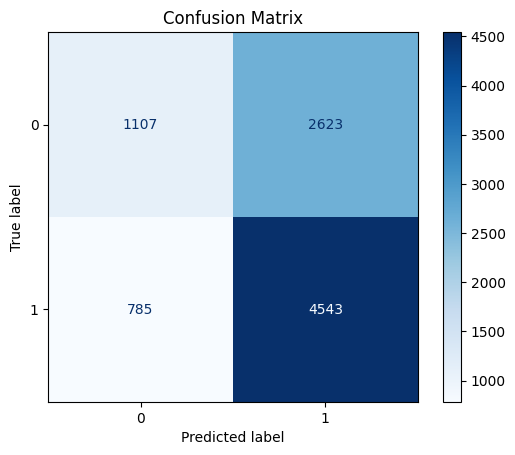

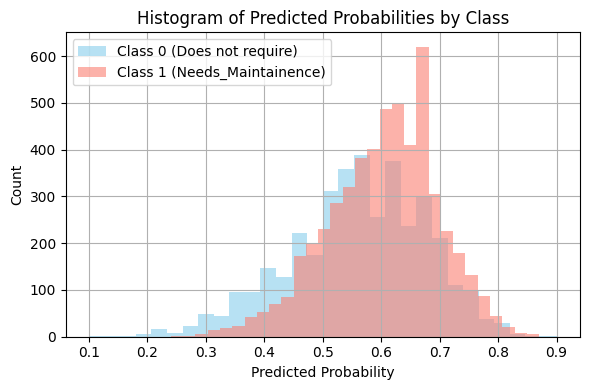

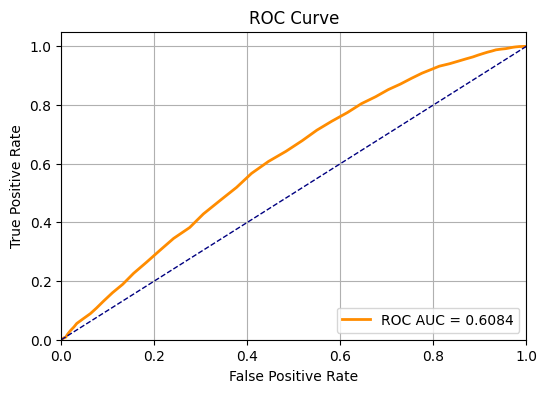


Fold 4 - Classification Report:
              precision    recall  f1-score   support

           0     0.5976    0.3118    0.4098      3730
           1     0.6391    0.8530    0.7307      5328

    accuracy                         0.6302      9058
   macro avg     0.6183    0.5824    0.5703      9058
weighted avg     0.6220    0.6302    0.5986      9058

Fold 4 - AUC-ROC: 0.6091
MCC: 0.1975


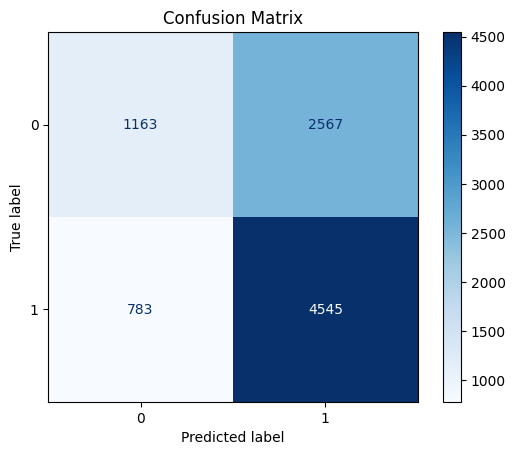

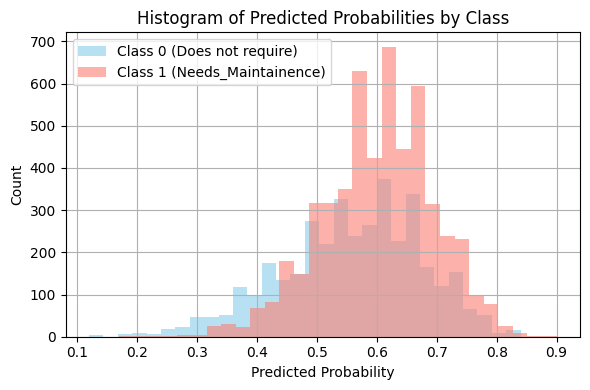

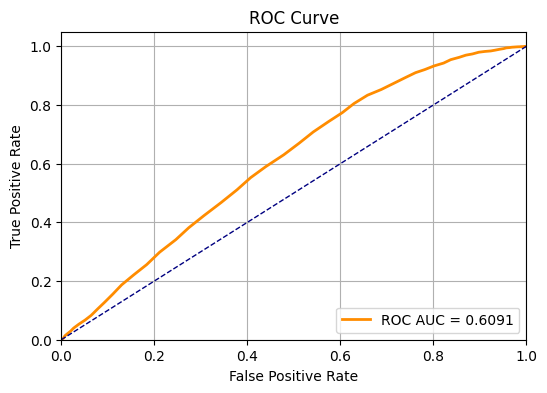


Fold 5 - Classification Report:
              precision    recall  f1-score   support

           0     0.5812    0.2965    0.3927      3730
           1     0.6333    0.8504    0.7259      5328

    accuracy                         0.6223      9058
   macro avg     0.6072    0.5735    0.5593      9058
weighted avg     0.6118    0.6223    0.5887      9058

Fold 5 - AUC-ROC: 0.6113
MCC: 0.1775


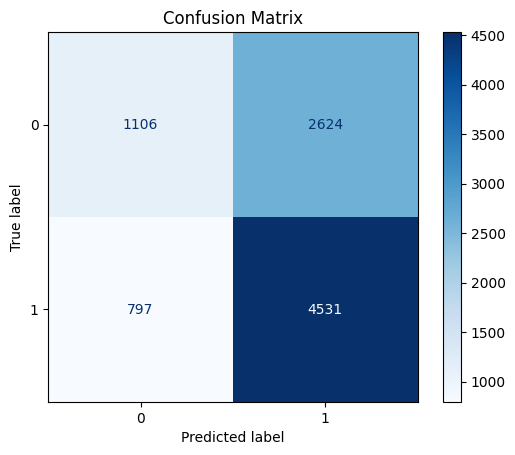

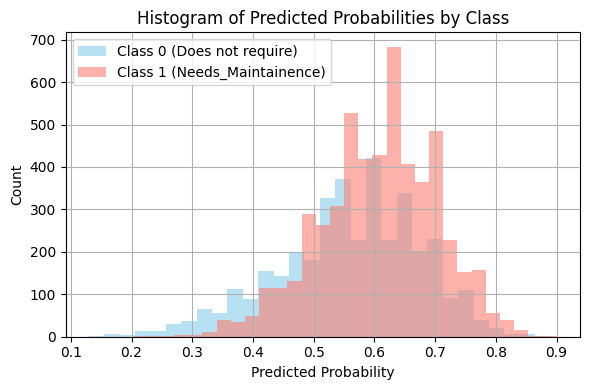

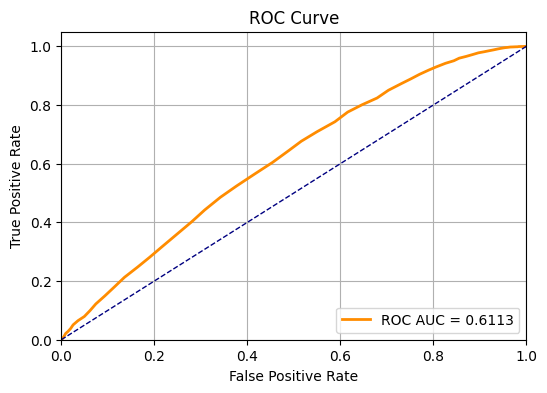


Average AUC-ROC across folds:
0.6108 ± 0.0022


In [113]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    matthews_corrcoef,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc  # re-importing packages so I can use it without any error
)

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for summary
roc_auc_scores = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_balanced, y_train_balanced), start=1):
    X_train_fold, X_val_fold = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]
    
    # Train the best model on this fold
    best_rf_M.fit(X_train_fold, y_train_fold)
    y_pred = best_rf_M.predict(X_val_fold)
    y_proba = best_rf_M.predict_proba(X_val_fold)[:, 1]
    
    # AUC for this fold
    roc_auc = roc_auc_score(y_val_fold, y_proba)
    roc_auc_scores.append(roc_auc)
    
    # Print classification report
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_pred, digits=4))
    print(f"Fold {fold} - AUC-ROC: {roc_auc:.4f}")
    mcc = matthews_corrcoef(y_val_fold, y_pred)
    print(f"MCC: {mcc:.4f}")
    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
    roc_auc_curve = auc(fpr, tpr)
    
    # historgraph of predicted probabilities
    plt.figure(figsize=(6, 4))
    plt.hist(y_proba[y_val_fold == 0], bins=30, alpha=0.6, label='Class 0 (Does not require)', color='skyblue')
    plt.hist(y_proba[y_val_fold == 1], bins=30, alpha=0.6, label='Class 1 (Needs_Maintainence)', color='salmon')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Histogram of Predicted Probabilities by Class')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Print average AUC over all folds
print("\nAverage AUC-ROC across folds:")
print(f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")



## TAB NET


==== Fold 1 ====
epoch 0  | loss: 0.73862 | val_auc: 0.51499 |  0:00:10s
epoch 1  | loss: 0.69416 | val_auc: 0.53331 |  0:00:20s
epoch 2  | loss: 0.69339 | val_auc: 0.53815 |  0:00:31s
epoch 3  | loss: 0.69292 | val_auc: 0.53089 |  0:00:41s
epoch 4  | loss: 0.69277 | val_auc: 0.54502 |  0:00:50s
epoch 5  | loss: 0.69199 | val_auc: 0.53341 |  0:01:00s
epoch 6  | loss: 0.69283 | val_auc: 0.53721 |  0:01:09s
epoch 7  | loss: 0.69194 | val_auc: 0.54032 |  0:01:21s
epoch 8  | loss: 0.69202 | val_auc: 0.5424  |  0:01:31s
epoch 9  | loss: 0.69166 | val_auc: 0.54612 |  0:01:51s
epoch 10 | loss: 0.69144 | val_auc: 0.53952 |  0:02:01s
epoch 11 | loss: 0.6909  | val_auc: 0.55133 |  0:02:12s
epoch 12 | loss: 0.69087 | val_auc: 0.5454  |  0:02:25s
epoch 13 | loss: 0.69113 | val_auc: 0.53313 |  0:02:36s
epoch 14 | loss: 0.69073 | val_auc: 0.54081 |  0:02:46s
epoch 15 | loss: 0.69203 | val_auc: 0.54166 |  0:02:56s
epoch 16 | loss: 0.69194 | val_auc: 0.536   |  0:03:06s
epoch 17 | loss: 0.69139 | val

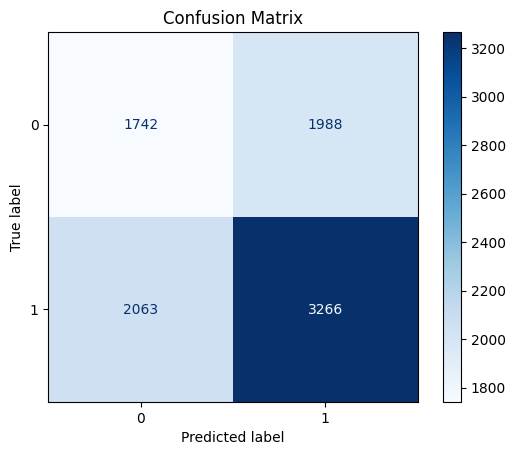

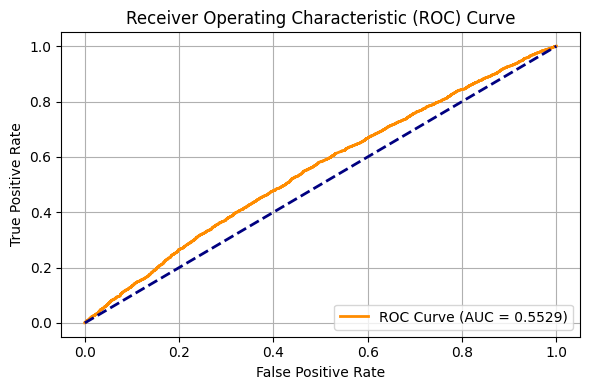

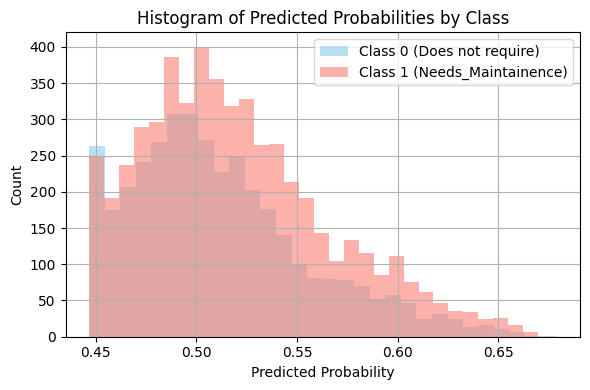


==== Fold 2 ====
epoch 0  | loss: 0.74367 | val_auc: 0.51752 |  0:00:09s
epoch 1  | loss: 0.69457 | val_auc: 0.52189 |  0:00:18s
epoch 2  | loss: 0.69358 | val_auc: 0.5221  |  0:00:27s
epoch 3  | loss: 0.69297 | val_auc: 0.52514 |  0:00:38s
epoch 4  | loss: 0.69195 | val_auc: 0.5362  |  0:00:48s
epoch 5  | loss: 0.69141 | val_auc: 0.53066 |  0:00:58s
epoch 6  | loss: 0.69216 | val_auc: 0.54248 |  0:01:08s
epoch 7  | loss: 0.6919  | val_auc: 0.54002 |  0:01:18s
epoch 8  | loss: 0.69249 | val_auc: 0.53261 |  0:01:27s
epoch 9  | loss: 0.69238 | val_auc: 0.52982 |  0:01:37s
epoch 10 | loss: 0.69158 | val_auc: 0.53861 |  0:01:46s
epoch 11 | loss: 0.6917  | val_auc: 0.534   |  0:01:56s
epoch 12 | loss: 0.69119 | val_auc: 0.53371 |  0:02:06s
epoch 13 | loss: 0.6917  | val_auc: 0.53483 |  0:02:15s
epoch 14 | loss: 0.69118 | val_auc: 0.53192 |  0:02:25s
epoch 15 | loss: 0.69228 | val_auc: 0.53583 |  0:02:34s
epoch 16 | loss: 0.69103 | val_auc: 0.52722 |  0:02:44s
epoch 17 | loss: 0.69155 | val

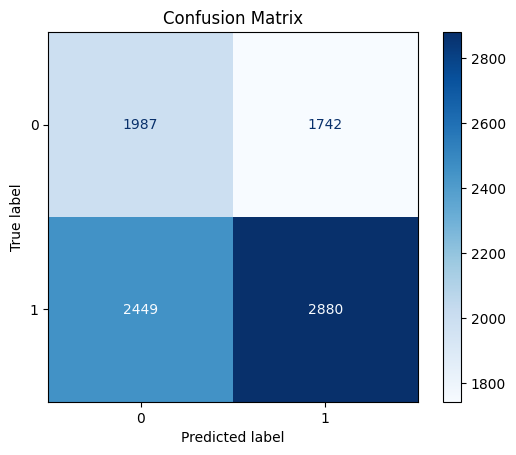

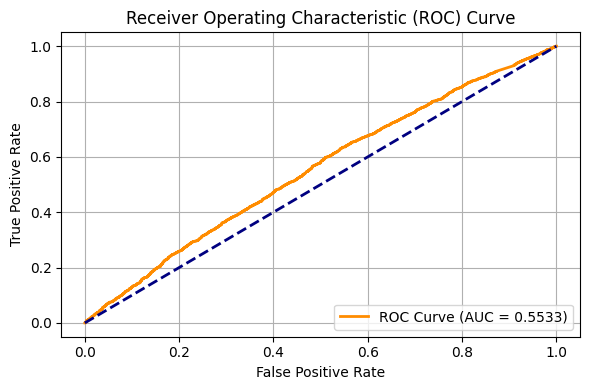

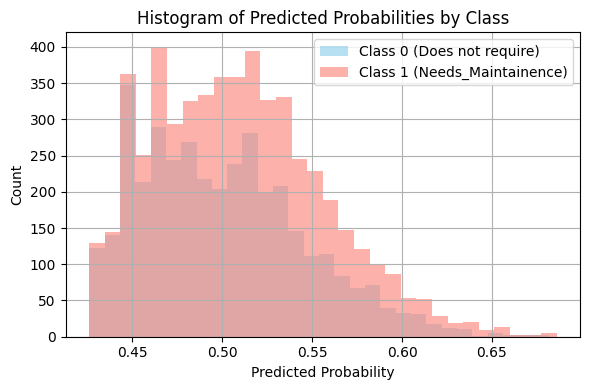


==== Fold 3 ====
epoch 0  | loss: 0.74304 | val_auc: 0.52747 |  0:00:11s
epoch 1  | loss: 0.69485 | val_auc: 0.51745 |  0:00:22s
epoch 2  | loss: 0.69377 | val_auc: 0.53443 |  0:00:34s
epoch 3  | loss: 0.69338 | val_auc: 0.52869 |  0:00:47s
epoch 4  | loss: 0.69234 | val_auc: 0.53622 |  0:00:59s
epoch 5  | loss: 0.69235 | val_auc: 0.5275  |  0:01:12s
epoch 6  | loss: 0.69239 | val_auc: 0.52821 |  0:01:25s
epoch 7  | loss: 0.69255 | val_auc: 0.53736 |  0:01:36s
epoch 8  | loss: 0.69244 | val_auc: 0.53165 |  0:01:46s
epoch 9  | loss: 0.6927  | val_auc: 0.53163 |  0:01:57s
epoch 10 | loss: 0.69191 | val_auc: 0.53879 |  0:02:07s
epoch 11 | loss: 0.69221 | val_auc: 0.54915 |  0:02:17s
epoch 12 | loss: 0.69166 | val_auc: 0.54173 |  0:02:27s
epoch 13 | loss: 0.69172 | val_auc: 0.54136 |  0:02:38s
epoch 14 | loss: 0.69246 | val_auc: 0.53891 |  0:02:48s
epoch 15 | loss: 0.69177 | val_auc: 0.54401 |  0:02:58s
epoch 16 | loss: 0.69112 | val_auc: 0.54718 |  0:03:08s
epoch 17 | loss: 0.69115 | val

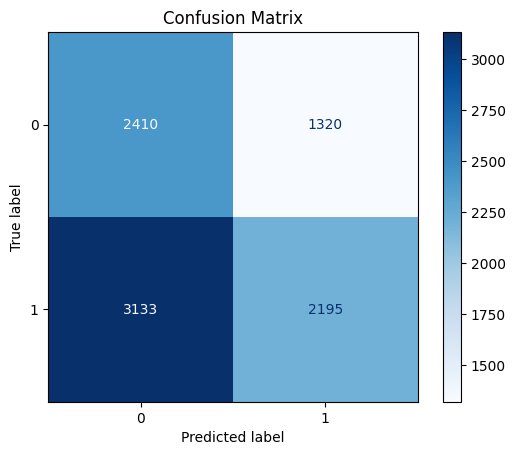

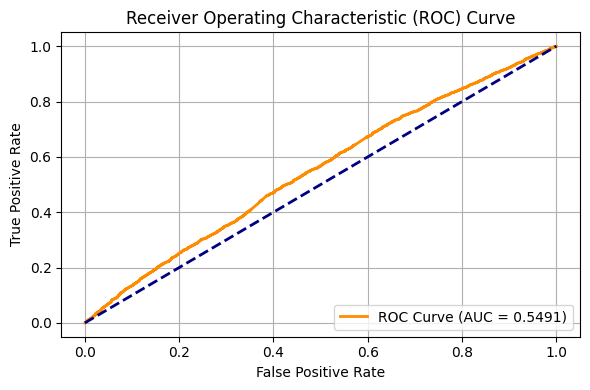

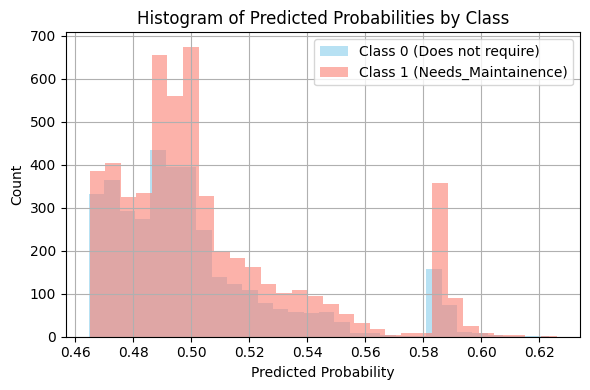


==== Fold 4 ====
epoch 0  | loss: 0.73705 | val_auc: 0.51952 |  0:00:10s
epoch 1  | loss: 0.69329 | val_auc: 0.53089 |  0:00:20s
epoch 2  | loss: 0.69252 | val_auc: 0.54646 |  0:00:31s
epoch 3  | loss: 0.69228 | val_auc: 0.54065 |  0:00:41s
epoch 4  | loss: 0.69184 | val_auc: 0.534   |  0:00:51s
epoch 5  | loss: 0.69193 | val_auc: 0.54657 |  0:01:01s
epoch 6  | loss: 0.69151 | val_auc: 0.55287 |  0:01:10s
epoch 7  | loss: 0.69107 | val_auc: 0.54494 |  0:01:20s
epoch 8  | loss: 0.69122 | val_auc: 0.52761 |  0:01:29s
epoch 9  | loss: 0.69107 | val_auc: 0.55175 |  0:01:38s
epoch 10 | loss: 0.68997 | val_auc: 0.54981 |  0:01:48s
epoch 11 | loss: 0.69011 | val_auc: 0.54628 |  0:01:58s
epoch 12 | loss: 0.69029 | val_auc: 0.54834 |  0:02:07s
epoch 13 | loss: 0.68975 | val_auc: 0.54966 |  0:02:15s
epoch 14 | loss: 0.68997 | val_auc: 0.54721 |  0:02:25s
epoch 15 | loss: 0.69032 | val_auc: 0.55026 |  0:02:36s
epoch 16 | loss: 0.69028 | val_auc: 0.55701 |  0:02:47s
epoch 17 | loss: 0.69031 | val

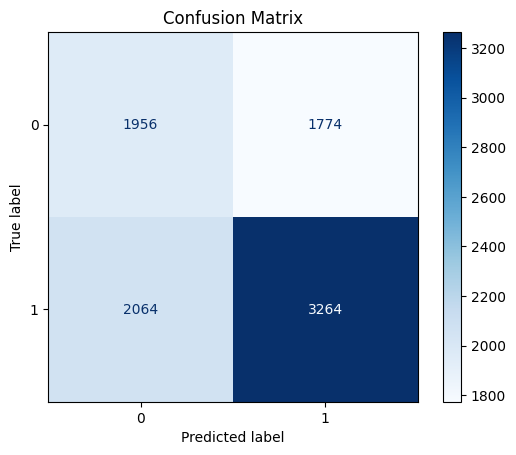

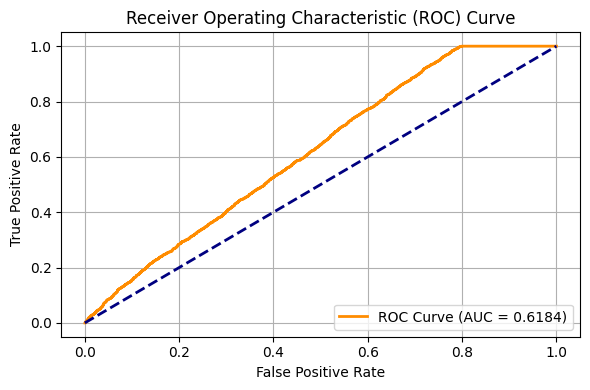

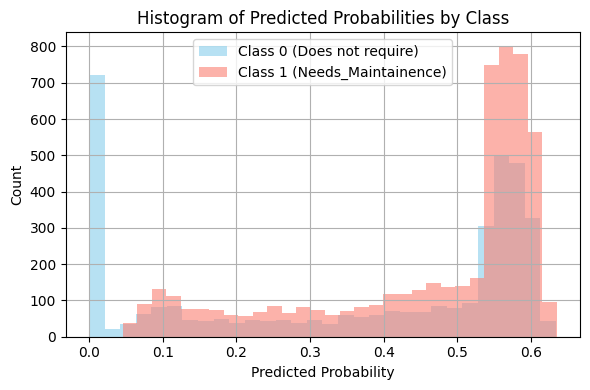


==== Fold 5 ====
epoch 0  | loss: 0.7381  | val_auc: 0.53926 |  0:00:09s
epoch 1  | loss: 0.69417 | val_auc: 0.54001 |  0:00:18s
epoch 2  | loss: 0.69334 | val_auc: 0.51119 |  0:00:28s
epoch 3  | loss: 0.69369 | val_auc: 0.52295 |  0:00:37s
epoch 4  | loss: 0.69285 | val_auc: 0.52012 |  0:00:46s
epoch 5  | loss: 0.69289 | val_auc: 0.53658 |  0:00:55s
epoch 6  | loss: 0.69219 | val_auc: 0.5421  |  0:01:04s
epoch 7  | loss: 0.69106 | val_auc: 0.54826 |  0:01:14s
epoch 8  | loss: 0.69029 | val_auc: 0.54747 |  0:01:24s
epoch 9  | loss: 0.69032 | val_auc: 0.54592 |  0:01:39s
epoch 10 | loss: 0.68874 | val_auc: 0.55297 |  0:01:51s
epoch 11 | loss: 0.69012 | val_auc: 0.54611 |  0:02:02s
epoch 12 | loss: 0.68962 | val_auc: 0.55438 |  0:02:14s
epoch 13 | loss: 0.69062 | val_auc: 0.54867 |  0:02:25s
epoch 14 | loss: 0.68956 | val_auc: 0.5475  |  0:02:39s
epoch 15 | loss: 0.69103 | val_auc: 0.55061 |  0:02:51s
epoch 16 | loss: 0.6898  | val_auc: 0.55431 |  0:03:03s
epoch 17 | loss: 0.68735 | val

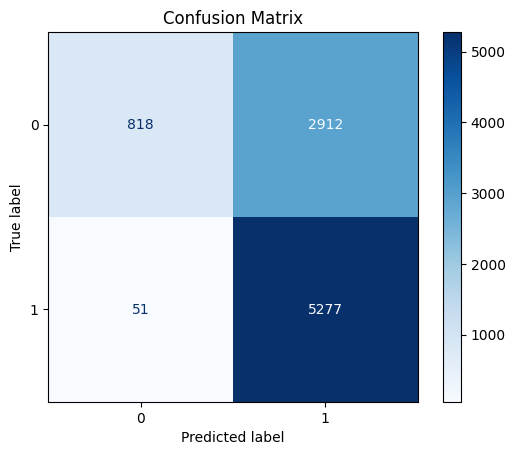

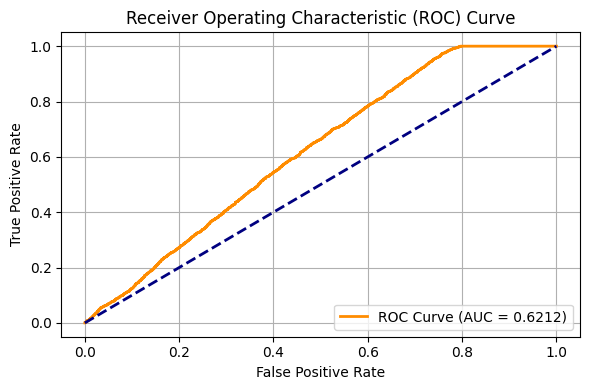

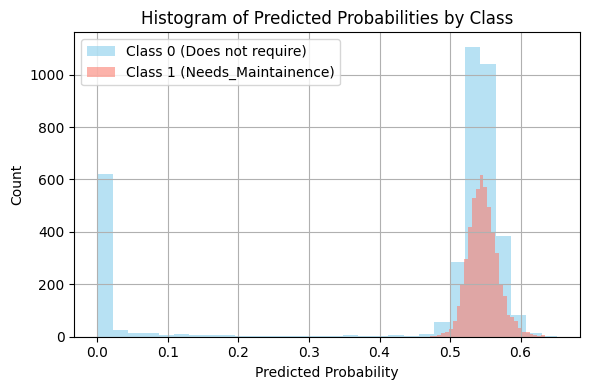


==== Cross-Validation Complete ====
Mean AUC: 0.5790 | Std AUC: 0.0334
Successfully saved model at Needs_Maintainence_tabnet_model.zip


'Needs_Maintainence_tabnet_model.zip'

In [114]:
# Configuration
TARGET_COL = 'Failure_Event'
CATEGORICAL_COLS = ['Asset_Type', 'Location']
RANDOM_STATE = 42
N_SPLITS = 5
EPOCHS = 100
BATCH_SIZE = 64

# Identify categorical feature indices and dimensions
cat_idxs = [X_train_balanced.columns.get_loc(col) for col in CATEGORICAL_COLS]
cat_dims = [int(df[col].nunique()) for col in CATEGORICAL_COLS]
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]

# Cross-validation setup
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

fold = 1
auc_scores = []
# Compute class weights for this fold
classes = np.unique(y_train_balanced)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_balanced)
weights = dict(zip(classes, class_weights))

for train_idx, val_idx in skf.split(X_train_balanced, y_train_balanced):
    print(f"\n==== Fold {fold} ====")
    
    TAB_X_train, TAB_X_val = X_train_balanced.values[train_idx], X_train_balanced.values[val_idx]
    TAB_y_train, TAB_y_val = y_train_balanced.values[train_idx], y_train_balanced.values[val_idx]

    # Initialize and train the model
    clf_M = TabNetClassifier(
        n_d=32, n_a=32, n_steps=5, gamma=1.5,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=RANDOM_STATE,
        verbose=1
    )

    clf_M.fit(
        X_train=TAB_X_train, y_train=TAB_y_train,
        eval_set=[(TAB_X_val, TAB_y_val)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=EPOCHS,
        patience=20,
        batch_size=BATCH_SIZE,
        virtual_batch_size=128,
        weights=weights
    )

    # Evaluation
    y_pred_proba = clf_M.predict_proba(TAB_X_val)[:, 1]
    y_pred = clf_M.predict(TAB_X_val)
    auc = roc_auc_score(TAB_y_val, y_pred_proba)
    auc_scores.append(auc)
    
    print(f"Fold {fold} AUC: {auc:.4f}")
    print(classification_report(TAB_y_val, y_pred, digits=4))
    mcc = matthews_corrcoef(TAB_y_val, y_pred)
    print(f"MCC: {mcc:.4f}")
    # Confusion matrix
    cm = confusion_matrix(TAB_y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(TAB_y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(6, 4))
    plt.hist(y_pred_proba[TAB_y_val == 0], bins=30, alpha=0.6, label='Class 0 (Does not require)', color='skyblue')
    plt.hist(y_pred_proba[TAB_y_val == 1], bins=30, alpha=0.6, label='Class 1 (Needs_Maintainence)', color='salmon')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Histogram of Predicted Probabilities by Class')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    fold += 1

# Final average AUC
print(f"\n==== Cross-Validation Complete ====")
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std AUC: {np.std(auc_scores):.4f}")
clf_M.save_model("Needs_Maintainence_tabnet_model")


### Extra evaluation on untrained data


Final Validation AUC: 0.6212
Classification Report:
              precision    recall  f1-score   support

           0     0.9413    0.2193    0.3557      3730
           1     0.6444    0.9904    0.7808      5328

    accuracy                         0.6729      9058
   macro avg     0.7929    0.6049    0.5683      9058
weighted avg     0.7667    0.6729    0.6058      9058

Matthews Correlation Coefficient (MCC): 0.3505


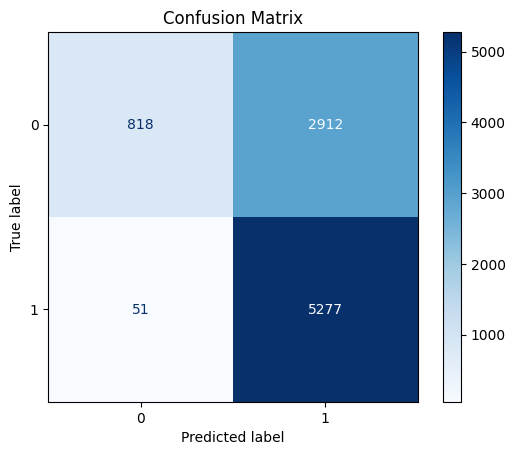

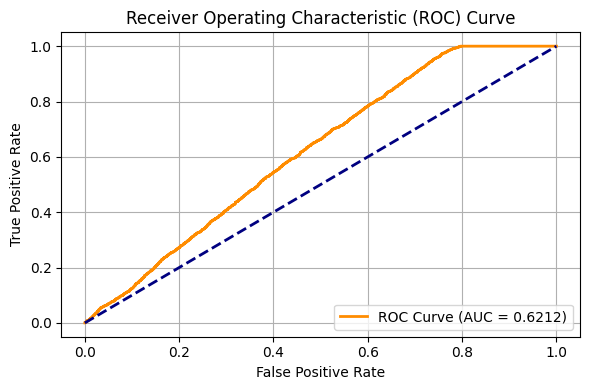

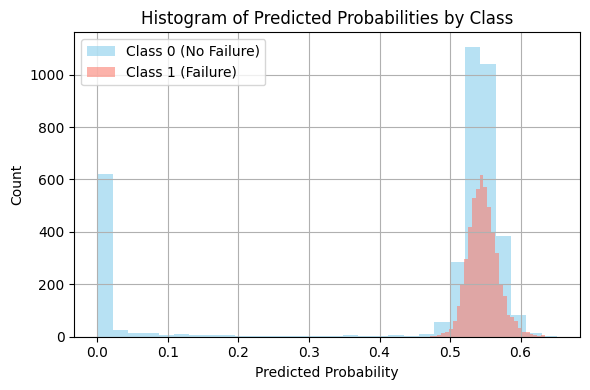

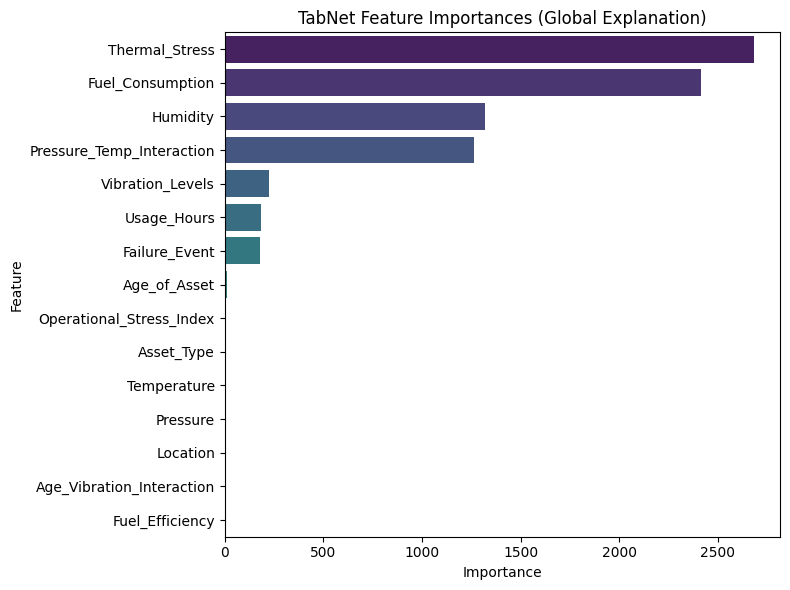

In [115]:
# Predict probabilities and labels

# Predict
TAB_x = TAB_X_val
TAB_y = TAB_y_val

y_pred_proba = clf_M.predict_proba(TAB_x)[:, 1]
y_pred = clf_M.predict(TAB_x)

# AUC
auc_score = roc_auc_score(TAB_y, y_pred_proba)
print(f"\nFinal Validation AUC: {auc_score:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(TAB_y, y_pred, digits=4))

# MCC
mcc = matthews_corrcoef(TAB_y, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Confusion matrix
cm = confusion_matrix(TAB_y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TAB_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(y_pred_proba[TAB_y == 0], bins=30, alpha=0.6, label='Class 0 (No Failure)', color='skyblue')
plt.hist(y_pred_proba[TAB_y == 1], bins=30, alpha=0.6, label='Class 1 (Failure)', color='salmon')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Histogram of Predicted Probabilities by Class')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

import seaborn as sns

# Explain method to get global feature importance
explain_matrix, masks = clf_M.explain(TAB_x)  # TAB_x should be your validation features

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': explain_matrix.sum(axis=0)
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature', palette='viridis')
plt.title("TabNet Feature Importances (Global Explanation)")
plt.tight_layout()
plt.show()


In [118]:
!jupyter nbconvert --to html Final_code.ipynb

[NbConvertApp] Converting notebook Final_code.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 77 image(s).
[NbConvertApp] Writing 4639485 bytes to Final_code.html
